# Plot Time Series w/ Observations (To get siphcat to get the text files -- USE THIS ONE!)

## Libraries

In [1]:
####################################################
####################################################
####################################################
#
# Libraries
#

import numpy             as np
import datetime          as datetime
import os                as os
import platform          as platform
import xarray            as xr
import pandas            as pd
import glob              as glob
import siphon.catalog    as siphcat  
import siphon.ncss       as siphncss
import seaborn           as sns
import matplotlib.pyplot as plt
import pint_xarray       as px
import pint              as pint
import matplotlib.dates  as mdates
import timezonefinder    as tzf
import pytz              as pytz
import haversine         as hs
import socket            as socket
import metpy.calc        as mpcalc
import metpy.units       as mpunits
import pathlib           as pathlib

import urllib.request
import shutil

import matplotlib.font_manager as fm
import matplotlib as mpl
import metpy.io          as mpio


from requests import HTTPError


from metpy.units import units

import airportsdata as airpt

ureg = pint.UnitRegistry()
Q_ = ureg.Quantity


def haversine(row):
    lon1 = station_lon
    lat1 = station_lat
    lon2 = row['longitude']
    lat2 = row['latitude']
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    km = 6367 * c
    return km
    
    
#
####################################################
####################################################
####################################################

## File Organization

In [2]:
####################################################
####################################################
####################################################
#
# File Organization
#

beta_on     = 0
max_domains = 2

if (socket.gethostname() == "kyrill"):
    WRF_OVERALL_DIR = "/projects/SD_Mines_WRF_REALTIME/"
else:
    if (platform.system() == "Darwin"):
         WRF_OVERALL_DIR = "/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/"
    else:
         WRF_OVERALL_DIR = "/home/wjc/GitHub/SD_Mines_WRF_REALTIME/"


os.chdir(WRF_OVERALL_DIR)

print( "Current Working Directory is now " + os.getcwd() )
    
WPS_WORK    = WRF_OVERALL_DIR + "./WPS_PrepArea/"
WPS_EXE     = WRF_OVERALL_DIR + "./WRF4/WPS/"
WRF_EXE     = WRF_OVERALL_DIR + "./WRF4/WRF/test/em_real/"
WRF_ARCHIVE = WRF_OVERALL_DIR + "./ARCHIVE/"
WRF_IMAGES  = WRF_OVERALL_DIR + "./WEB_IMAGES/"
METAR_DIR   = WRF_OVERALL_DIR + "./METARS/"



station_list_file = WRF_OVERALL_DIR + "namelist_files_and_local_scripts/time_series_station_files_"+str(max_domains)+"_dom_all.xlsx"

os.chdir(WRF_EXE)

#
####################################################
####################################################
####################################################

Current Working Directory is now /Users/wjc/GitHub/SD_Mines_WRF_REALTIME


## Time Control

In [3]:
####################################################
####################################################
####################################################
#
# Model Start Date
#

with open(WRF_ARCHIVE  + "./current_complete_run/current_run.txt") as f:
    model_start_date_YYYY_MM_DD_HH = f.readlines()

model_start_date_YYYY_MM_DD_HH     = model_start_date_YYYY_MM_DD_HH[0][0:13]

model_start_date_YYYY_MM_DD_HH0000 = model_start_date_YYYY_MM_DD_HH + ":00:00"
print(model_start_date_YYYY_MM_DD_HH0000)
    
model_start_datetime = datetime.datetime.strptime(model_start_date_YYYY_MM_DD_HH0000, '%Y-%m-%d_%H:%M:%S')
print("Model Simulation Date ", model_start_datetime)
    
model_end_datetime   = model_start_datetime + datetime.timedelta(hours=36)
current_datetime     = datetime.datetime.utcnow()
siphon_end_datetime  = min(current_datetime,model_end_datetime)

print("         Model Start Datetime is ", model_start_datetime)
print("           Model End Datetime is ",   model_end_datetime)
print("             Current Datetime is ",     current_datetime)
print("          Siphon End Datetime is ",  siphon_end_datetime)


siphon_time_series       = pd.date_range(model_start_datetime, siphon_end_datetime,freq='H')
siphon_pulls_YYYYMMDD_HH = siphon_time_series.strftime("%Y%m%d_%H00")

print(siphon_pulls_YYYYMMDD_HH)

#
####################################################
####################################################
####################################################

2022-09-29_18:00:00
Model Simulation Date  2022-09-29 18:00:00
         Model Start Datetime is  2022-09-29 18:00:00
           Model End Datetime is  2022-10-01 06:00:00
             Current Datetime is  2022-10-23 05:10:10.748302
          Siphon End Datetime is  2022-10-01 06:00:00
Index(['20220929_1800', '20220929_1900', '20220929_2000', '20220929_2100',
       '20220929_2200', '20220929_2300', '20220930_0000', '20220930_0100',
       '20220930_0200', '20220930_0300', '20220930_0400', '20220930_0500',
       '20220930_0600', '20220930_0700', '20220930_0800', '20220930_0900',
       '20220930_1000', '20220930_1100', '20220930_1200', '20220930_1300',
       '20220930_1400', '20220930_1500', '20220930_1600', '20220930_1700',
       '20220930_1800', '20220930_1900', '20220930_2000', '20220930_2100',
       '20220930_2200', '20220930_2300', '20221001_0000', '20221001_0100',
       '20221001_0200', '20221001_0300', '20221001_0400', '20221001_0500',
       '20221001_0600'],
      dtype='o

## Read tslist excel file



In [4]:
####################################################
####################################################
####################################################
#
# Read TSLIST Excel File
#

print("read file from "+station_list_file)

available_time_series_list = pd.read_excel(station_list_file,
                                           index_col=0)

print(available_time_series_list)

#
####################################################
####################################################
####################################################

read file from /Users/wjc/GitHub/SD_Mines_WRF_REALTIME/namelist_files_and_local_scripts/time_series_station_files_2_dom_all.xlsx
          Station ID  Domain            Station Name  Latitude  Longitude  \
Row Label                                                                   
26              KUNR       2      Rapid City NWS, SD   44.0727   -103.211   
21              KRCA       2       Ellsworth AFB, SD   44.1330   -103.100   
20              KRAP       2     Rapid City Arpt, SD   44.0430   -103.054   
25              KUDX       2  Rapid City, NEXRAD, SD   44.1330   -102.833   
7               KCUT       2         Custer Arpt, SD   43.7330   -103.611   
23              KSPF       2     Clyde Ice Field, SD   44.4830   -103.783   
10              KEFC       2  Belle Fourche Muni, SD   44.7340   -103.862   
6               KCDR       2     Chadron Airport, NE   42.8370   -103.098   
15              KIEN       2     Pine Ridge Arpt, SD   43.0210   -102.518   
28              KW43    

## Get Station Information

In [5]:
####################################################
####################################################
####################################################
#
# Airport Data
#

airport_database = airpt.load('ICAO')

#
####################################################
####################################################
####################################################

## Pull METARS from Siphon Services

In [6]:
####################################################
####################################################
####################################################
#
# Pull METARS from UNIDATA NOAAPORT Experimental Site
#
# https://thredds-test.unidata.ucar.edu/thredds/fileServer/noaaport/text/metar/metar_20210924_0000.txt


try: 
    cat = siphcat.TDSCatalog('https://thredds-dev.unidata.ucar.edu/thredds/catalog/noaaport/text/metar/catalog.xml')

    first = True
    for datehour in siphon_pulls_YYYYMMDD_HH:



        metar_url  = "https://thredds-dev.unidata.ucar.edu/thredds/fileServer/noaaport/text/metar/metar_"+datehour+".txt"
        metar_file = METAR_DIR + "./metar_"+datehour+".txt"


        path_to_file = pathlib.Path(metar_file)

        print(path_to_file, path_to_file.is_file())



        if (not path_to_file.is_file()) :

            print("downloading "+ metar_url)
            with urllib.request.urlopen(metar_url) as response, open(metar_file, 'wb') as out_file:
                shutil.copyfileobj(response, out_file)
        print("cracking "+metar_file)
        try:
            indata = mpio.metar.parse_metar_file(metar_file)
            if first:
                first = False
                metar_dataframe = indata
            else:
                metar_dataframe = pd.concat([metar_dataframe,indata])
                metar_dataframe = metar_dataframe.drop_duplicates()
        except ValueError:
            print("BALLS! Parse Error")
            error_404 = True
            pass




    metar_station_locs = metar_dataframe[["station_id","latitude","longitude"]].drop_duplicates()

except:
    print("Balls - we cannot access the thredds server")
    metar_dataframe = pd.DataFrame()

#
####################################################
####################################################
####################################################

/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/METARS/metar_20220929_1800.txt True
cracking /Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./METARS/./metar_20220929_1800.txt
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/METARS/metar_20220929_1900.txt True
cracking /Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./METARS/./metar_20220929_1900.txt
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/METARS/metar_20220929_2000.txt True
cracking /Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./METARS/./metar_20220929_2000.txt
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/METARS/metar_20220929_2100.txt True
cracking /Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./METARS/./metar_20220929_2100.txt
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/METARS/metar_20220929_2200.txt True
cracking /Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./METARS/./metar_20220929_2200.txt
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/METARS/metar_20220929_2300.txt True
cracking /Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./METARS/./metar_20220929_2300.txt
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/

/opt/miniconda3/lib/python3.9/site-packages/pint/quantity.py:1568: RuntimeWarning: invalid value encountered in power
  magnitude = new_self._magnitude**exponent


/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/METARS/metar_20220930_0900.txt True
cracking /Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./METARS/./metar_20220930_0900.txt
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/METARS/metar_20220930_1000.txt True
cracking /Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./METARS/./metar_20220930_1000.txt
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/METARS/metar_20220930_1100.txt True
cracking /Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./METARS/./metar_20220930_1100.txt
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/METARS/metar_20220930_1200.txt True
cracking /Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./METARS/./metar_20220930_1200.txt
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/METARS/metar_20220930_1300.txt True
cracking /Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./METARS/./metar_20220930_1300.txt
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/METARS/metar_20220930_1400.txt True
cracking /Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./METARS/./metar_20220930_1400.txt


/opt/miniconda3/lib/python3.9/site-packages/pint/quantity.py:1568: RuntimeWarning: invalid value encountered in power
  magnitude = new_self._magnitude**exponent


/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/METARS/metar_20220930_1500.txt True
cracking /Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./METARS/./metar_20220930_1500.txt
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/METARS/metar_20220930_1600.txt True
cracking /Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./METARS/./metar_20220930_1600.txt
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/METARS/metar_20220930_1700.txt True
cracking /Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./METARS/./metar_20220930_1700.txt


/opt/miniconda3/lib/python3.9/site-packages/pint/quantity.py:1568: RuntimeWarning: invalid value encountered in power
  magnitude = new_self._magnitude**exponent


/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/METARS/metar_20220930_1800.txt True
cracking /Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./METARS/./metar_20220930_1800.txt
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/METARS/metar_20220930_1900.txt True
cracking /Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./METARS/./metar_20220930_1900.txt
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/METARS/metar_20220930_2000.txt True
cracking /Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./METARS/./metar_20220930_2000.txt
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/METARS/metar_20220930_2100.txt True
cracking /Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./METARS/./metar_20220930_2100.txt


/opt/miniconda3/lib/python3.9/site-packages/pint/quantity.py:1568: RuntimeWarning: invalid value encountered in power
  magnitude = new_self._magnitude**exponent


/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/METARS/metar_20220930_2200.txt True
cracking /Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./METARS/./metar_20220930_2200.txt


/opt/miniconda3/lib/python3.9/site-packages/pint/quantity.py:1568: RuntimeWarning: invalid value encountered in power
  magnitude = new_self._magnitude**exponent


/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/METARS/metar_20220930_2300.txt True
cracking /Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./METARS/./metar_20220930_2300.txt


/opt/miniconda3/lib/python3.9/site-packages/pint/quantity.py:1568: RuntimeWarning: invalid value encountered in power
  magnitude = new_self._magnitude**exponent


/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/METARS/metar_20221001_0000.txt True
cracking /Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./METARS/./metar_20221001_0000.txt
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/METARS/metar_20221001_0100.txt True
cracking /Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./METARS/./metar_20221001_0100.txt
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/METARS/metar_20221001_0200.txt True
cracking /Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./METARS/./metar_20221001_0200.txt
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/METARS/metar_20221001_0300.txt True
cracking /Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./METARS/./metar_20221001_0300.txt
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/METARS/metar_20221001_0400.txt True
cracking /Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./METARS/./metar_20221001_0400.txt
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/METARS/metar_20221001_0500.txt True
cracking /Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./METARS/./metar_20221001_0500.txt
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/

## Rotate through Available Files

Creating /Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./WEB_IMAGES/./current_complete_run/STATION_TIME_SERIES/
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d02_2022-09-29_18_KUNR.nc
Weatherstation from airport database  Ellsworth Air Force Base
lon metar/station/wrf: -103.08 -103.211 [-103.201]
lat metar/station/wrf: 44.13 44.0727 [44.064]
distance between  metar and tslist  12.248076856135103
distance between  metar and    wrf  12.133622306515543
distance between tslist and    wrf  1.2546616892833835
Total precip:  8.736011811023623  in
DatetimeIndex(['2022-10-29 11:55:00-06:00', '2022-10-29 12:55:00-06:00',
               '2022-10-29 13:55:00-06:00', '2022-10-29 14:55:00-06:00',
               '2022-10-29 15:55:00-06:00', '2022-10-29 16:55:00-06:00',
               '2022-10-29 17:55:00-06:00', '2022-10-29 18:55:00-06:00',
               '2022-10-29 19:55:00-06:00', '2022-10-29 20:55:00-06:00',
               '2022-10-29 21:55:00-06:

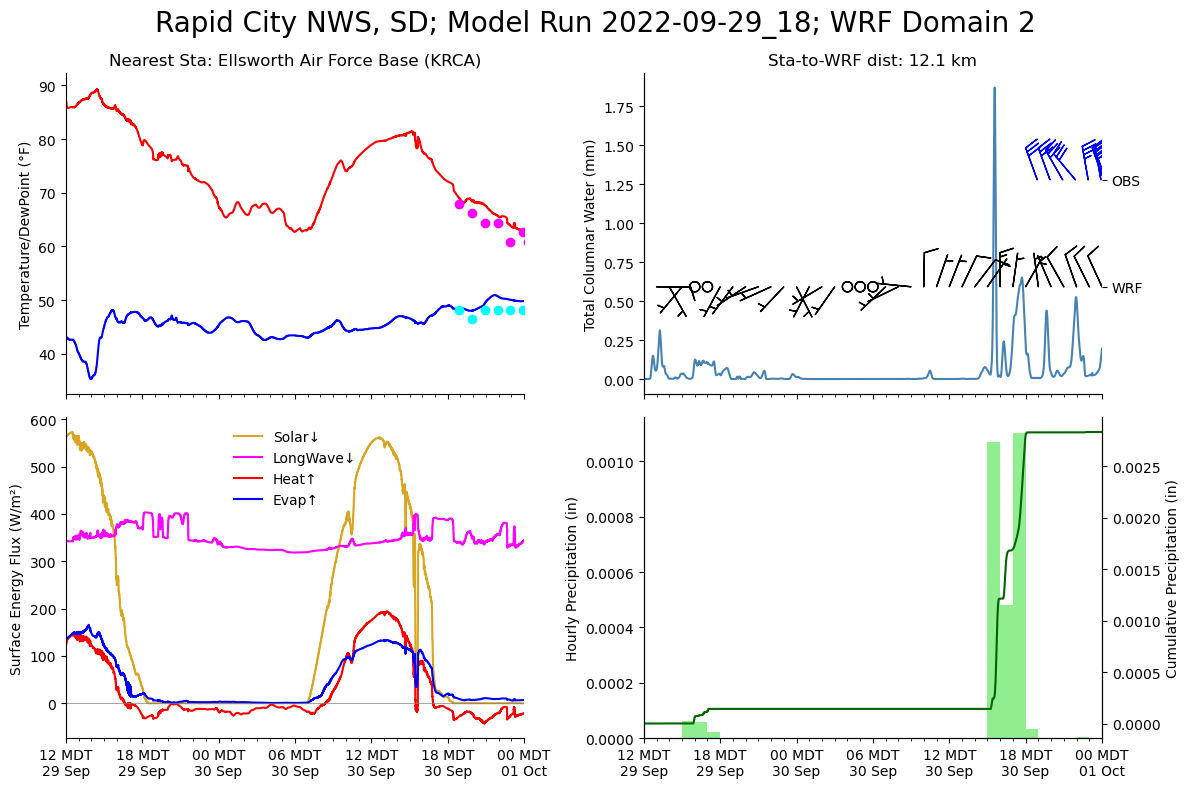

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d02_2022-09-29_18_KRCA.nc
Weatherstation from airport database  Ellsworth Air Force Base
lon metar/station/wrf: -103.08 -103.1 [-103.088]
lat metar/station/wrf: 44.13 44.133 [44.146]
distance between  metar and tslist  1.6306763023763868
distance between  metar and    wrf  1.8901944284525458
distance between tslist and    wrf  1.7339386800389782
Total precip:  3.292705511811023  in
DatetimeIndex(['2022-10-29 11:55:00-06:00', '2022-10-29 12:55:00-06:00',
               '2022-10-29 13:55:00-06:00', '2022-10-29 14:55:00-06:00',
               '2022-10-29 15:55:00-06:00', '2022-10-29 16:55:00-06:00',
               '2022-10-29 17:55:00-06:00', '2022-10-29 18:55:00-06:00',
               '2022-10-29 19:55:00-06:00', '2022-10-29 20:55:00-06:00',
               '2022-10-29 21:55:00-06:00', '2022-10-29 22:55:00-06:00',
               '2022-10-29 23:55:00-06:00', '2022-10-30 00:55:00-06:00',


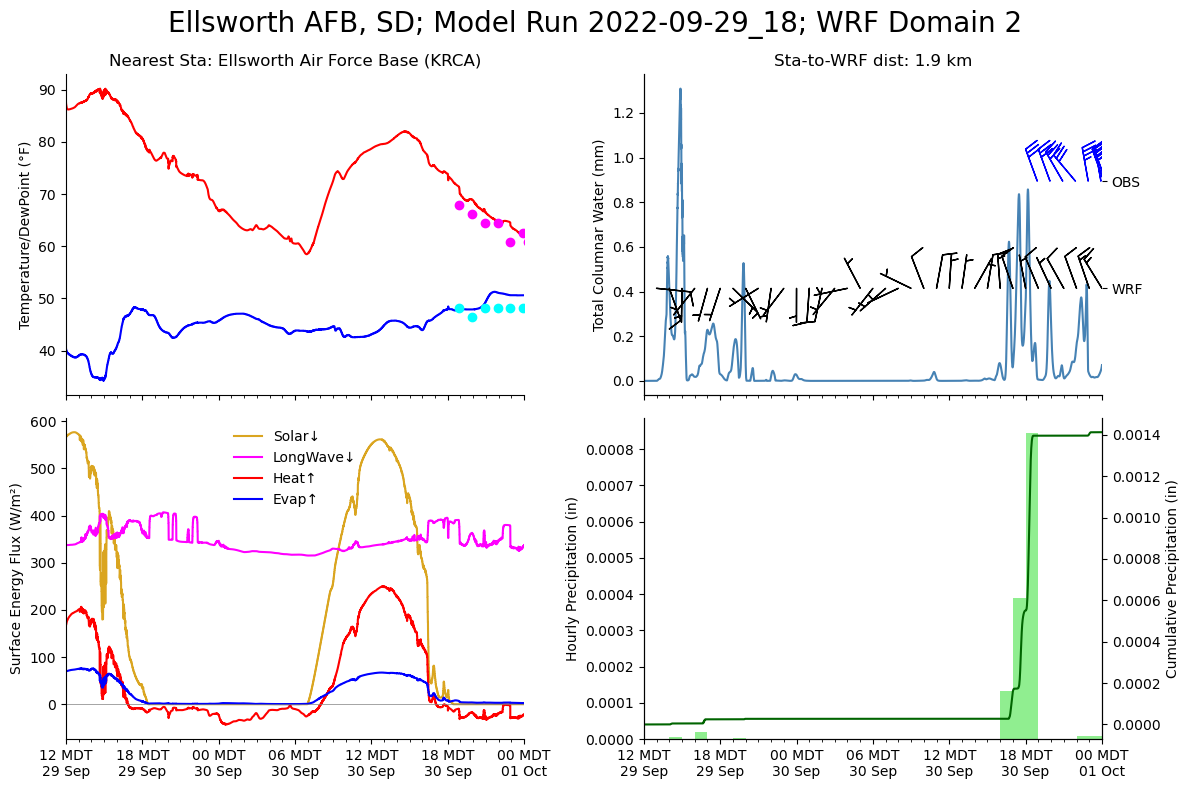

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d02_2022-09-29_18_KRAP.nc
Weatherstation from airport database  Rapid City Regional Airport
lon metar/station/wrf: -103.05 -103.054 [-103.05]
lat metar/station/wrf: 44.05 44.043 [44.038]
distance between  metar and tslist  0.8414626128192473
distance between  metar and    wrf  1.3343409628024534
distance between tslist and    wrf  0.6413546080681104
Total precip:  35.80797677165356  in
DatetimeIndex(['2022-10-29 11:52:00-06:00', '2022-10-29 12:52:00-06:00',
               '2022-10-29 13:52:00-06:00', '2022-10-29 14:52:00-06:00',
               '2022-10-29 15:52:00-06:00', '2022-10-29 16:52:00-06:00',
               '2022-10-29 17:52:00-06:00', '2022-10-29 18:52:00-06:00',
               '2022-10-29 19:52:00-06:00', '2022-10-29 20:52:00-06:00',
               '2022-10-29 21:52:00-06:00', '2022-10-29 22:52:00-06:00',
               '2022-10-29 23:52:00-06:00', '2022-10-30 00:52:00-06:0

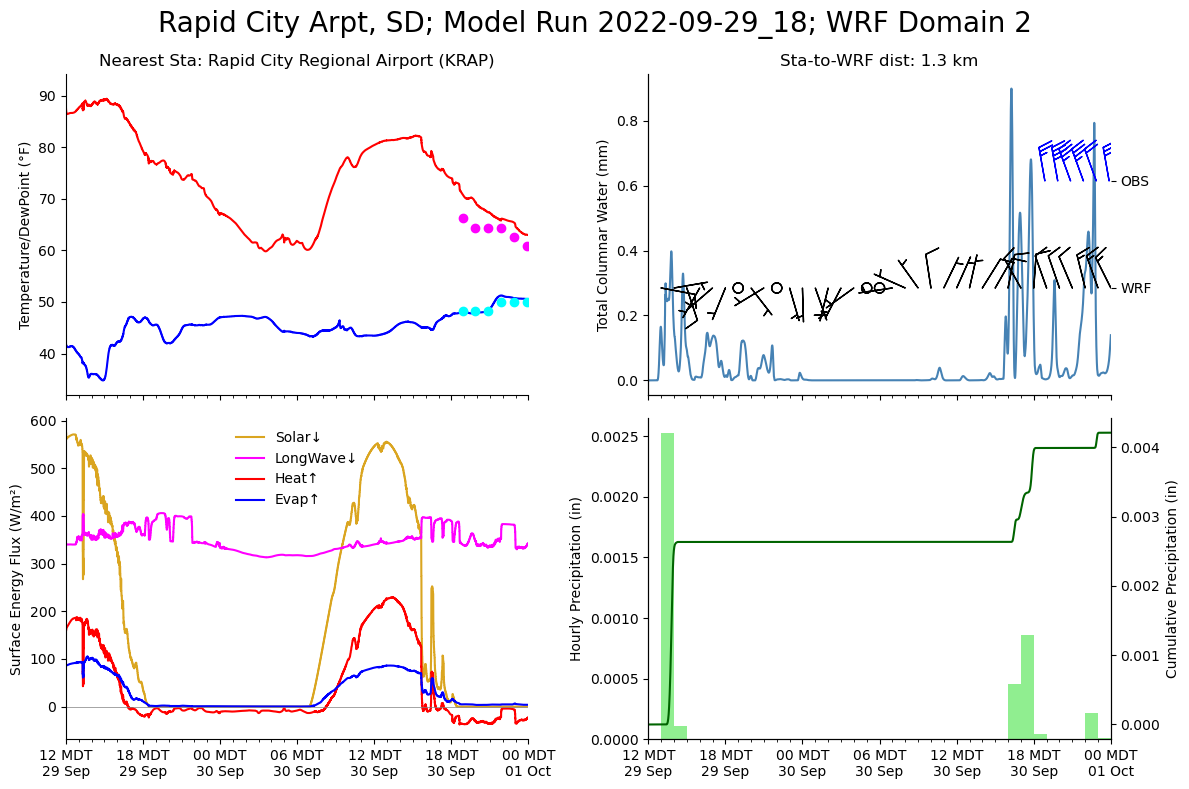

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d02_2022-09-29_18_KUDX.nc
Weatherstation from airport database  Rapid City Regional Airport
lon metar/station/wrf: -103.05 -102.833 [-102.825]
lat metar/station/wrf: 44.05 44.133 [44.146]
distance between  metar and tslist  19.634671810868664
distance between  metar and    wrf  20.89914758750576
distance between tslist and    wrf  1.580226623927318
Total precip:  263.0008208661418  in
DatetimeIndex(['2022-10-29 11:52:00-06:00', '2022-10-29 12:52:00-06:00',
               '2022-10-29 13:52:00-06:00', '2022-10-29 14:52:00-06:00',
               '2022-10-29 15:52:00-06:00', '2022-10-29 16:52:00-06:00',
               '2022-10-29 17:52:00-06:00', '2022-10-29 18:52:00-06:00',
               '2022-10-29 19:52:00-06:00', '2022-10-29 20:52:00-06:00',
               '2022-10-29 21:52:00-06:00', '2022-10-29 22:52:00-06:00',
               '2022-10-29 23:52:00-06:00', '2022-10-30 00:52:00-06:00

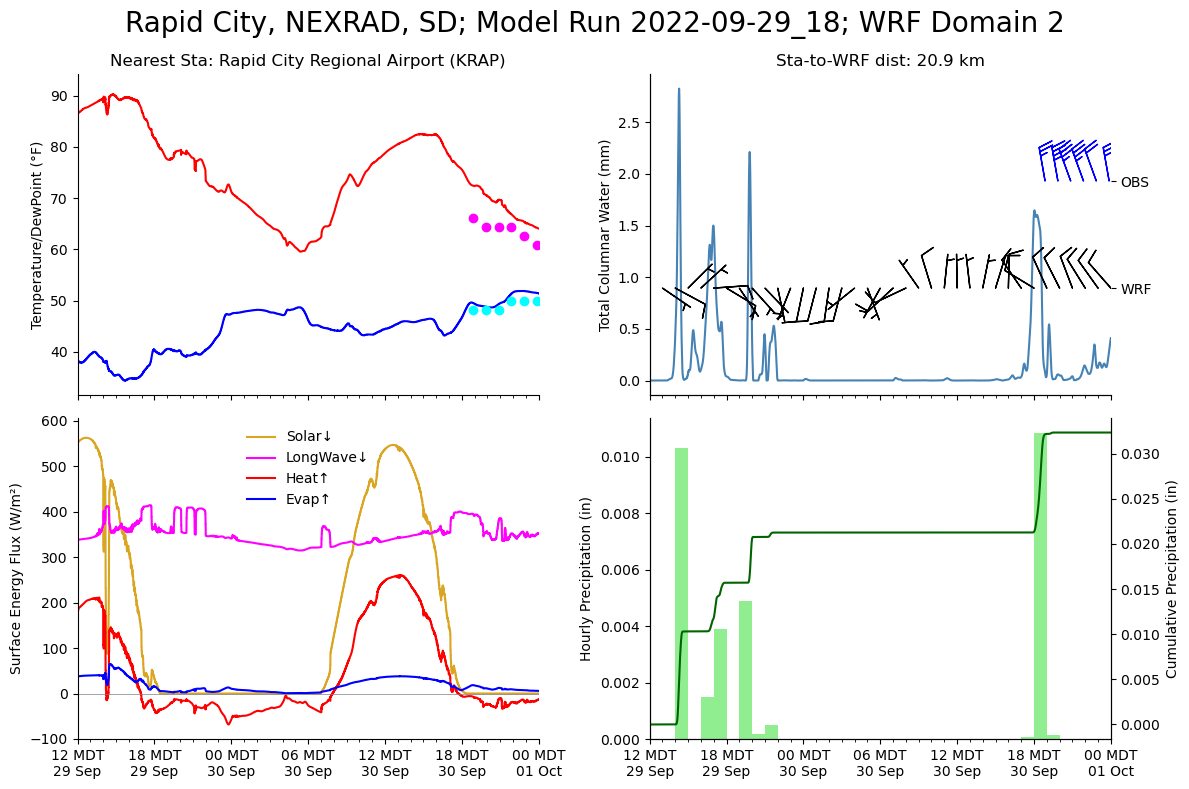

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d02_2022-09-29_18_KCUT.nc
Weatherstation from airport database  Custer County Airport
lon metar/station/wrf: -103.62 -103.611 [-103.609]
lat metar/station/wrf: 43.73 43.733 [43.738]
distance between  metar and tslist  0.7963672843281203
distance between  metar and    wrf  1.253956782361837
distance between tslist and    wrf  0.5787300692258683
Total precip:  4.066105511811024  in
DatetimeIndex(['2022-10-29 11:53:00-06:00', '2022-10-29 12:53:00-06:00',
               '2022-10-29 13:53:00-06:00', '2022-10-29 14:53:00-06:00',
               '2022-10-29 15:53:00-06:00', '2022-10-29 16:53:00-06:00',
               '2022-10-29 17:53:00-06:00', '2022-10-29 18:53:00-06:00',
               '2022-10-29 19:53:00-06:00', '2022-10-29 20:53:00-06:00',
               '2022-10-29 21:53:00-06:00', '2022-10-29 22:53:00-06:00',
               '2022-10-29 23:53:00-06:00', '2022-10-30 00:53:00-06:00',
  

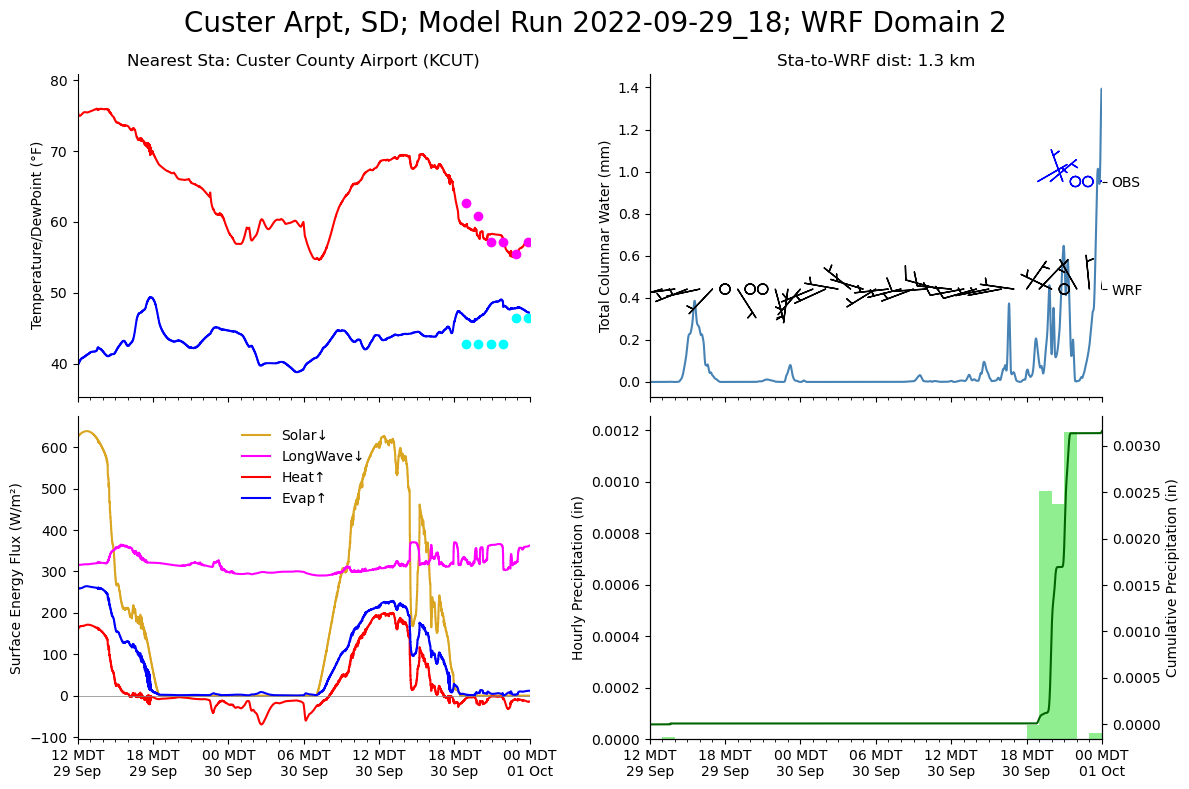

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d02_2022-09-29_18_KSPF.nc
Weatherstation from airport database  Black Hills Clyde Ice Field
lon metar/station/wrf: -103.77 -103.783 [-103.771]
lat metar/station/wrf: 44.47 44.483 [44.492]
distance between  metar and tslist  1.7757963329263085
distance between  metar and    wrf  2.447577897868054
distance between tslist and    wrf  1.381184271598091
Total precip:  2.5810425196850395  in
DatetimeIndex(['2022-10-29 11:55:00-06:00', '2022-10-29 12:15:00-06:00',
               '2022-10-29 12:35:00-06:00', '2022-10-29 12:55:00-06:00',
               '2022-10-29 13:15:00-06:00', '2022-10-29 13:35:00-06:00',
               '2022-10-29 13:55:00-06:00', '2022-10-29 14:15:00-06:00',
               '2022-10-29 14:35:00-06:00', '2022-10-29 14:55:00-06:00',
               ...
               '2022-09-30 21:35:00-06:00', '2022-09-30 21:55:00-06:00',
               '2022-09-30 22:15:00-06:00', '2022-

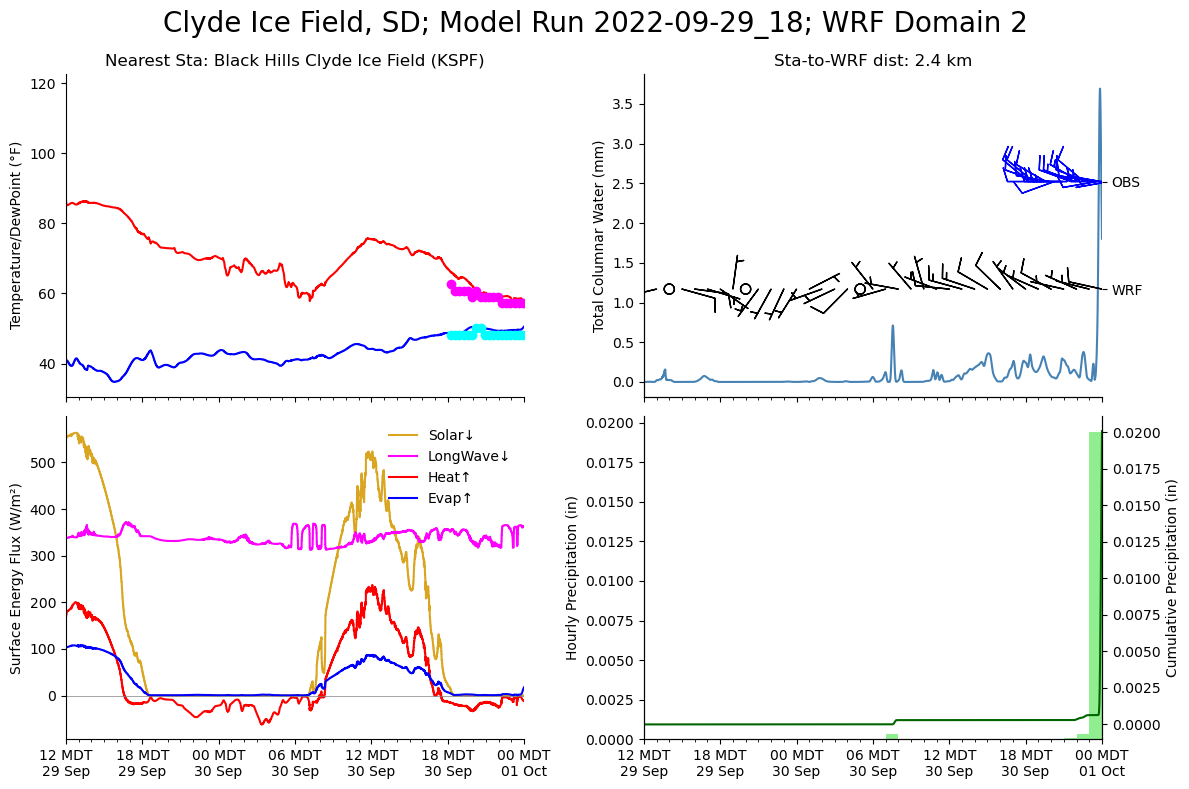

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d02_2022-09-29_18_KEFC.nc
Weatherstation from airport database  Black Hills Clyde Ice Field
lon metar/station/wrf: -103.77 -103.862 [-103.852]
lat metar/station/wrf: 44.47 44.734 [44.735]
distance between  metar and tslist  30.245626446148954
distance between  metar and    wrf  30.17335889793137
distance between tslist and    wrf  0.797691047828645
Total precip:  13.796470078740159  in
DatetimeIndex(['2022-10-29 11:55:00-06:00', '2022-10-29 12:15:00-06:00',
               '2022-10-29 12:35:00-06:00', '2022-10-29 12:55:00-06:00',
               '2022-10-29 13:15:00-06:00', '2022-10-29 13:35:00-06:00',
               '2022-10-29 13:55:00-06:00', '2022-10-29 14:15:00-06:00',
               '2022-10-29 14:35:00-06:00', '2022-10-29 14:55:00-06:00',
               ...
               '2022-09-30 21:35:00-06:00', '2022-09-30 21:55:00-06:00',
               '2022-09-30 22:15:00-06:00', '2022-

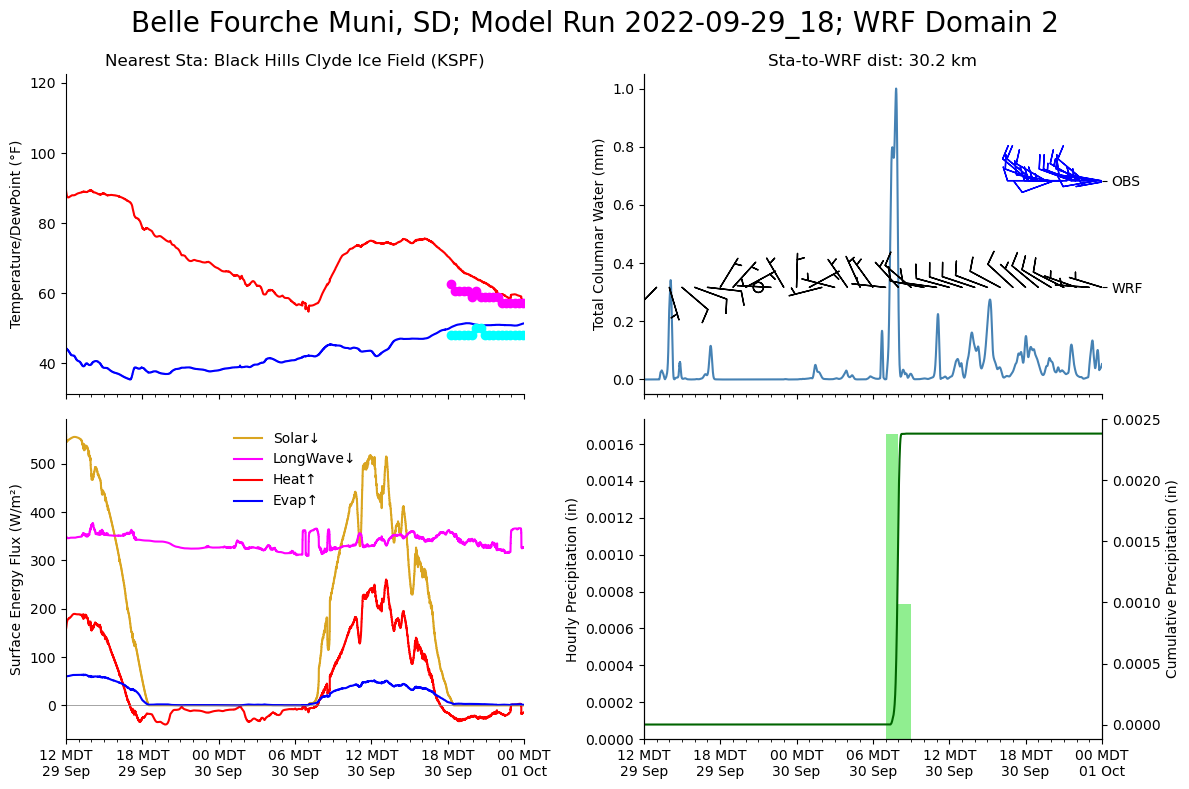

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d02_2022-09-29_18_KCDR.nc
Weatherstation from airport database  Chadron Municipal Airport
lon metar/station/wrf: -103.1 -103.098 [-103.081]
lat metar/station/wrf: 42.83 42.837 [42.824]
distance between  metar and tslist  0.7952672301072319
distance between  metar and    wrf  1.6870098978676618
distance between tslist and    wrf  2.002846889466035
Total precip:  62.42207559055118  in
DatetimeIndex(['2022-10-29 11:53:00-06:00', '2022-10-29 12:53:00-06:00',
               '2022-10-29 13:53:00-06:00', '2022-10-29 14:53:00-06:00',
               '2022-10-29 15:53:00-06:00', '2022-10-29 16:51:00-06:00',
               '2022-10-29 16:53:00-06:00', '2022-10-30 04:53:00-06:00',
               '2022-10-30 05:53:00-06:00', '2022-10-30 06:53:00-06:00',
               '2022-10-30 07:53:00-06:00', '2022-10-30 08:53:00-06:00',
               '2022-10-30 09:53:00-06:00', '2022-10-30 10:53:00-06:00',

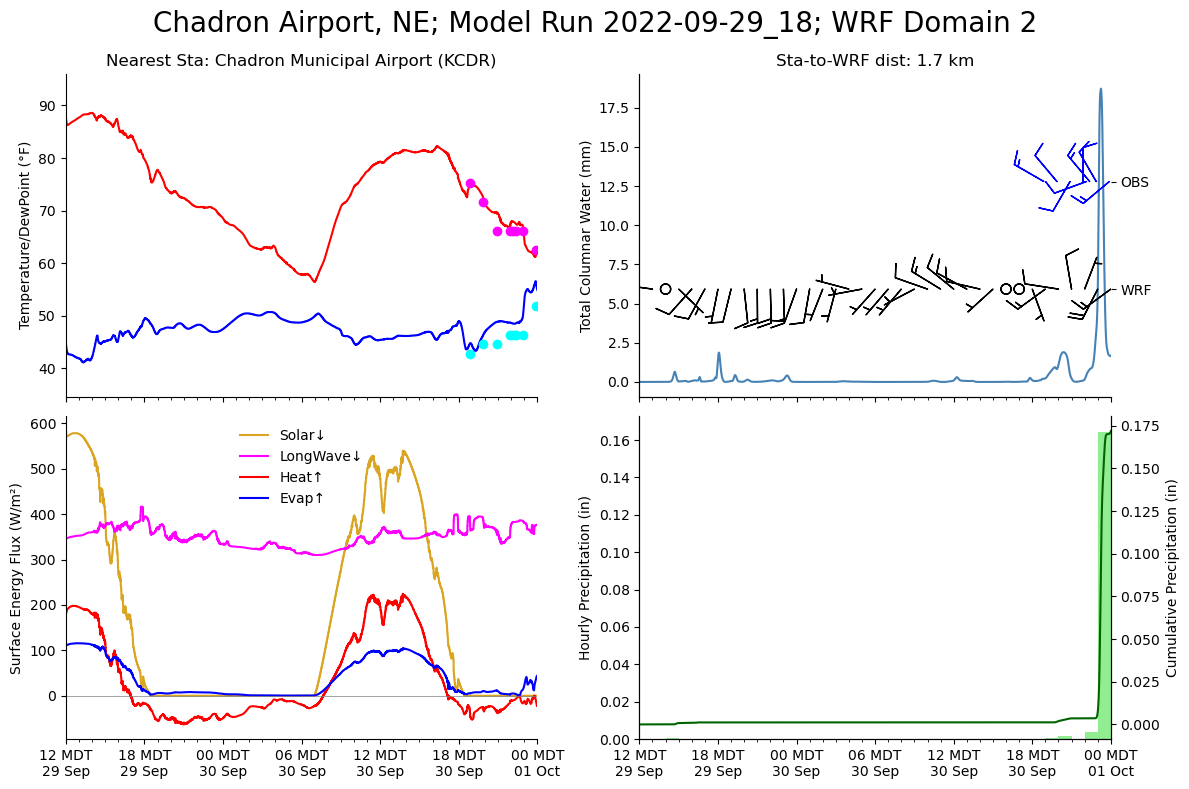

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d02_2022-09-29_18_KIEN.nc
Weatherstation from airport database  Pine Ridge Airport
lon metar/station/wrf: -102.52 -102.518 [-102.529]
lat metar/station/wrf: 43.03 43.021 [43.013]
distance between  metar and tslist  1.0138756011863506
distance between  metar and    wrf  2.0269701563286637
distance between tslist and    wrf  1.261387754002912
Total precip:  36.063708267716535  in
DatetimeIndex(['2022-10-29 11:52:00-06:00', '2022-10-29 12:52:00-06:00',
               '2022-10-29 13:52:00-06:00', '2022-10-29 14:52:00-06:00',
               '2022-10-29 15:20:00-06:00', '2022-10-29 15:43:00-06:00',
               '2022-10-29 15:52:00-06:00', '2022-10-29 16:52:00-06:00',
               '2022-10-29 17:52:00-06:00', '2022-10-29 18:41:00-06:00',
               '2022-10-29 18:52:00-06:00', '2022-10-29 19:52:00-06:00',
               '2022-10-29 20:52:00-06:00', '2022-10-29 21:52:00-06:00',
    

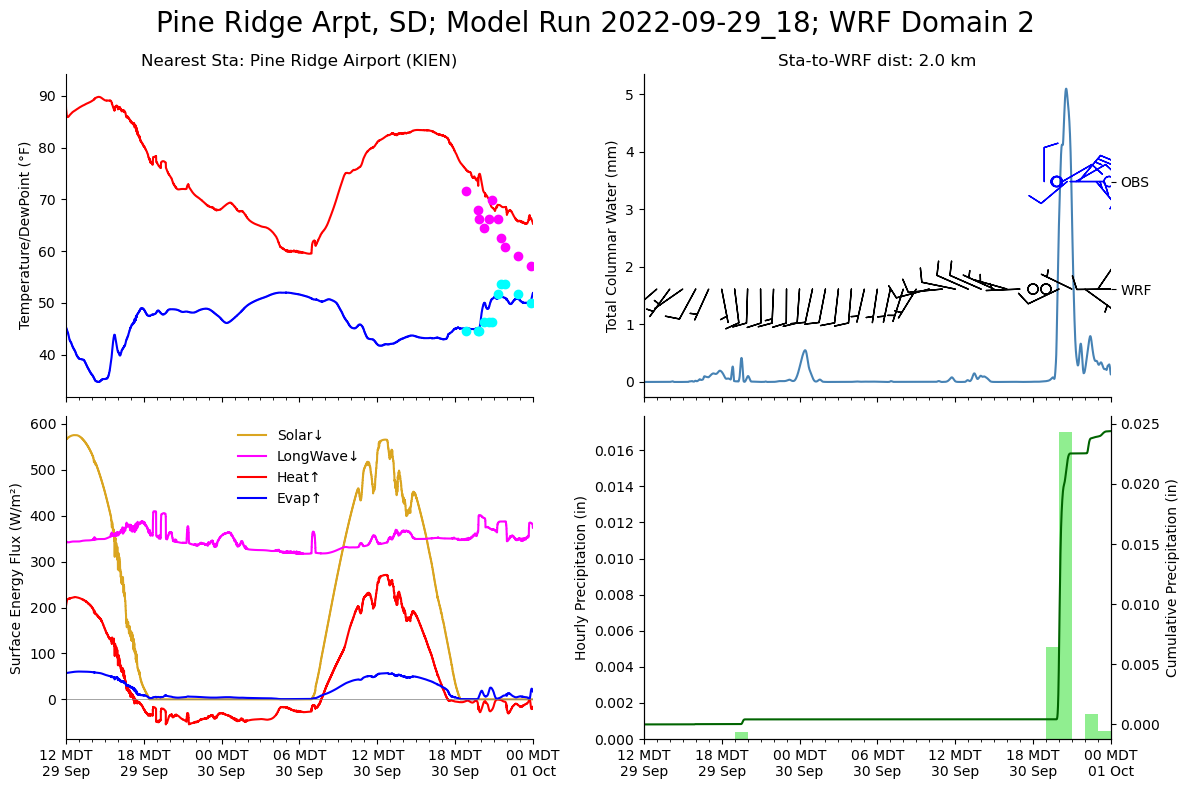

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d02_2022-09-29_18_KW43.nc
Weatherstation from airport database  Hulett Municipal Airport
lon metar/station/wrf: -104.57 -104.568 [-104.571]
lat metar/station/wrf: 44.67 44.6629 [44.671]
distance between  metar and tslist  0.8051728253837324
distance between  metar and    wrf  0.1364464101921689
distance between tslist and    wrf  0.9314027696001868
Total precip:  4.847218897637796  in
DatetimeIndex(['2022-10-29 12:15:00-06:00', '2022-10-29 12:35:00-06:00',
               '2022-10-29 11:55:00-06:00', '2022-10-29 12:55:00-06:00',
               '2022-10-29 13:15:00-06:00', '2022-10-29 13:35:00-06:00',
               '2022-10-29 13:55:00-06:00', '2022-10-29 14:15:00-06:00',
               '2022-10-29 14:35:00-06:00', '2022-10-29 14:55:00-06:00',
               ...
               '2022-09-30 21:35:00-06:00', '2022-09-30 21:55:00-06:00',
               '2022-09-30 22:15:00-06:00', '2022-0

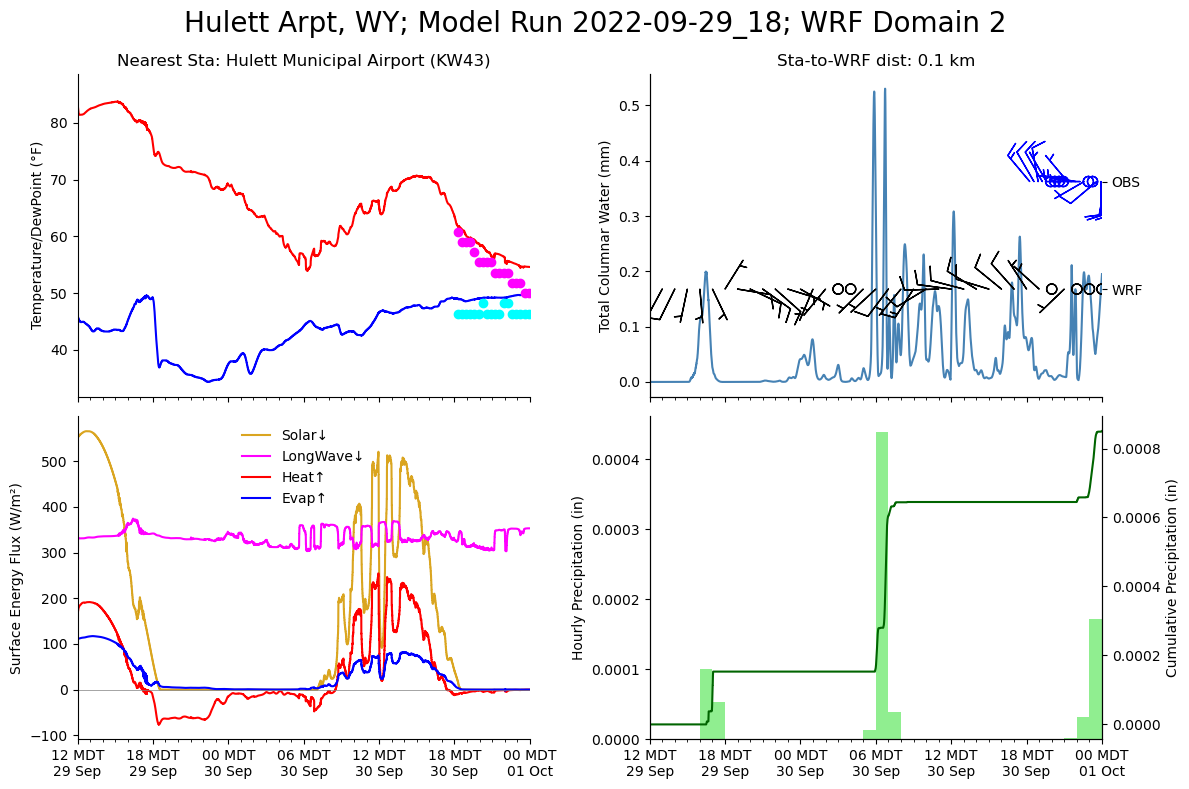

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d02_2022-09-29_18_KD07.nc
Weatherstation from airport database  Faith Municipal Airport
lon metar/station/wrf: -102.02 -102.019 [-102.025]
lat metar/station/wrf: 45.03 45.032 [45.034]
distance between  metar and tslist  0.23586620497680477
distance between  metar and    wrf  0.5934738563248113
distance between tslist and    wrf  0.5213053234830398
Total precip:  0.8526547244094491  in
DatetimeIndex(['2022-10-29 11:56:00-06:00', '2022-10-29 12:56:00-06:00',
               '2022-10-29 12:56:00-06:00', '2022-10-29 13:56:00-06:00',
               '2022-10-29 13:56:00-06:00', '2022-10-29 14:56:00-06:00',
               '2022-10-29 14:56:00-06:00', '2022-10-29 15:56:00-06:00',
               '2022-10-29 16:56:00-06:00', '2022-10-29 16:56:00-06:00',
               '2022-10-29 17:56:00-06:00', '2022-10-29 17:56:00-06:00',
               '2022-10-29 18:56:00-06:00', '2022-10-29 18:56:00-06:00

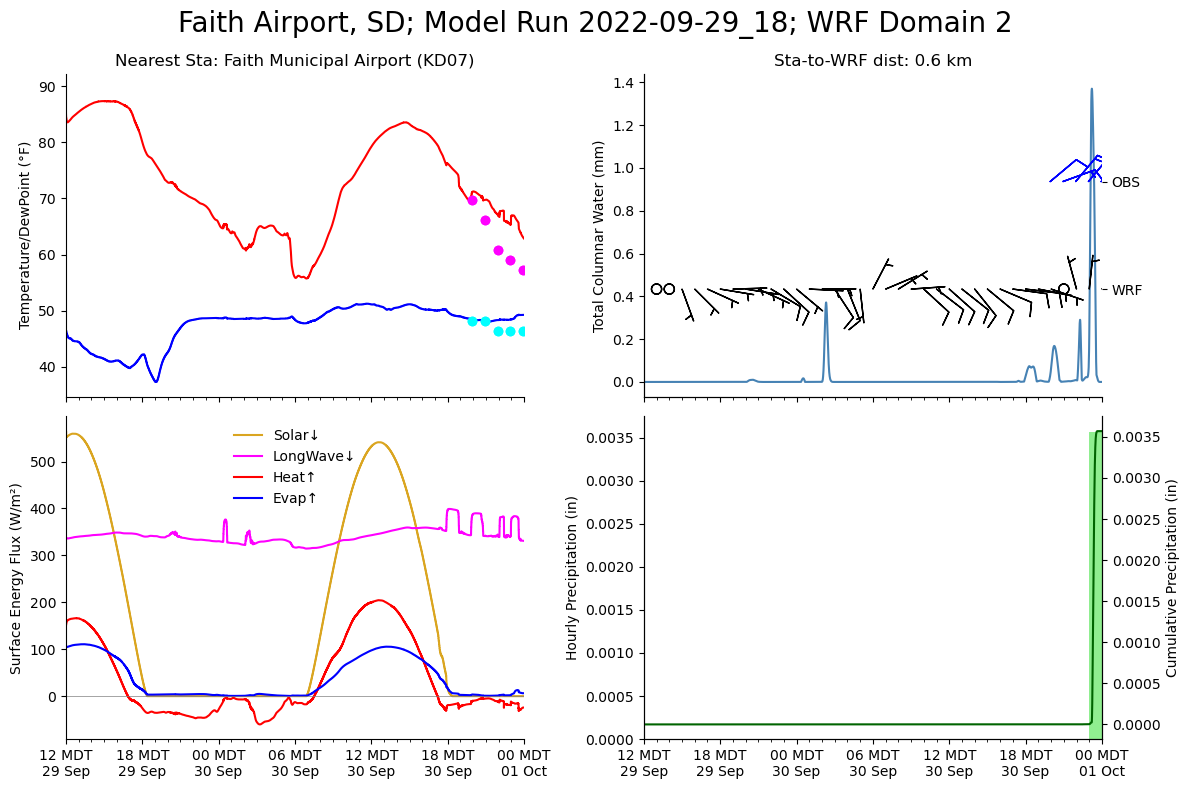

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d02_2022-09-29_18_K2WX.nc
Weatherstation from short table  K2WX
lon metar/station/wrf: -103.55 -103.546 [-103.56]
lat metar/station/wrf: 45.6 45.604 [45.6]
distance between  metar and tslist  0.5428313569026182
distance between  metar and    wrf  0.7779912123453261
distance between tslist and    wrf  1.1764670823789947
Total precip:  0.0  in
No Significant Rainfall
DatetimeIndex(['2022-10-29 11:56:00-06:00', '2022-10-29 12:56:00-06:00',
               '2022-10-29 13:56:00-06:00', '2022-10-29 13:56:00-06:00',
               '2022-10-29 14:56:00-06:00', '2022-10-29 14:56:00-06:00',
               '2022-10-29 15:56:00-06:00', '2022-10-29 15:56:00-06:00',
               '2022-10-29 16:56:00-06:00', '2022-10-29 16:56:00-06:00',
               '2022-10-29 17:56:00-06:00', '2022-10-29 17:56:00-06:00',
               '2022-10-29 18:56:00-06:00', '2022-10-29 19:56:00-06:00',
               '2

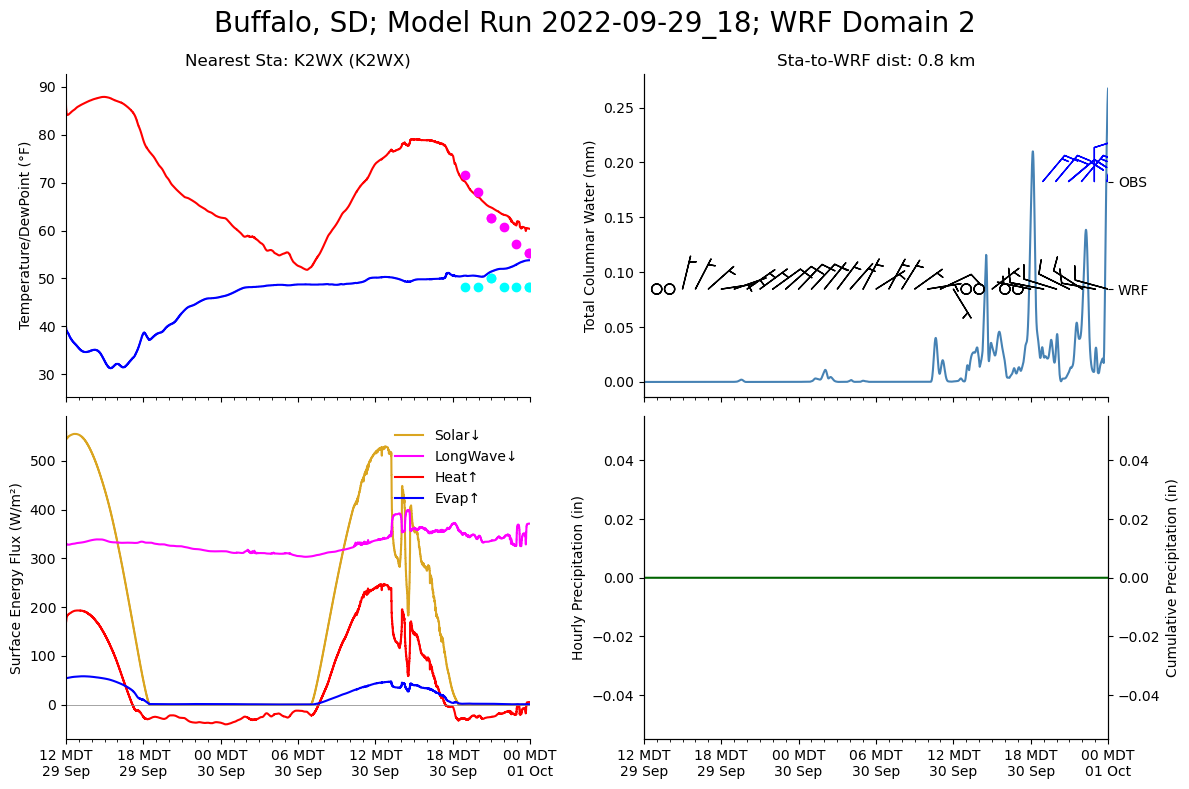

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d02_2022-09-29_18_KPHP.nc
Weatherstation from airport database  Philip Airport
lon metar/station/wrf: -101.6 -101.601 [-101.586]
lat metar/station/wrf: 44.05 44.051 [44.059]
distance between  metar and tslist  0.13693568566437198
distance between  metar and    wrf  1.5010669513782708
distance between tslist and    wrf  1.492709910775782
Total precip:  0.009661417322834648  in
DatetimeIndex(['2022-10-29 11:55:00-06:00', '2022-10-29 12:55:00-06:00',
               '2022-10-29 13:55:00-06:00', '2022-10-29 14:55:00-06:00',
               '2022-10-29 15:55:00-06:00', '2022-10-29 16:55:00-06:00',
               '2022-10-29 17:55:00-06:00', '2022-10-29 18:55:00-06:00',
               '2022-10-29 19:55:00-06:00', '2022-10-29 20:55:00-06:00',
               '2022-10-29 21:55:00-06:00', '2022-10-29 22:55:00-06:00',
               '2022-10-29 23:55:00-06:00', '2022-10-30 00:55:00-06:00',
      

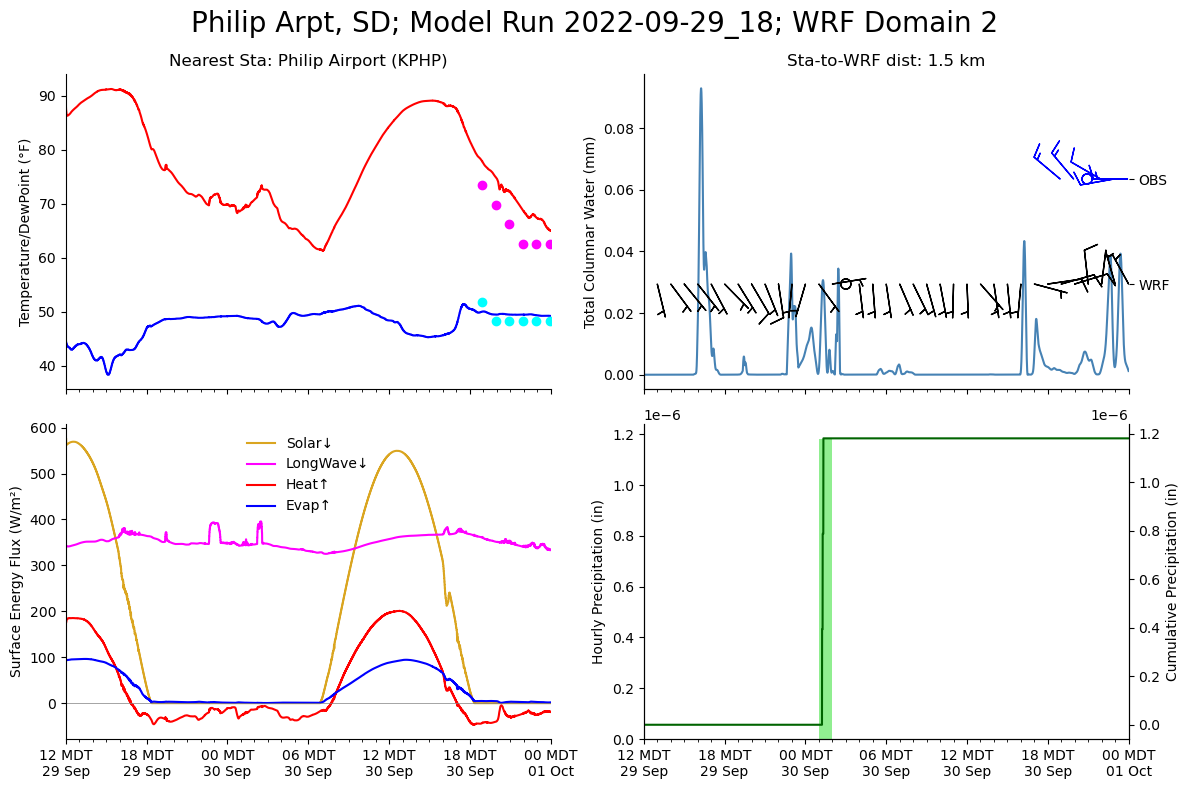

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d02_2022-09-29_18_KGRN.nc
Weatherstation from airport database  Pine Ridge Airport
lon metar/station/wrf: -102.52 -102.175 [-102.162]
lat metar/station/wrf: 43.03 42.806 [42.796]
distance between  metar and tslist  37.545330184291736
distance between  metar and    wrf  39.0770902971485
distance between tslist and    wrf  1.5366653826675085
Total precip:  116.71596574803151  in
DatetimeIndex(['2022-10-29 11:52:00-06:00', '2022-10-29 12:52:00-06:00',
               '2022-10-29 13:52:00-06:00', '2022-10-29 14:52:00-06:00',
               '2022-10-29 15:20:00-06:00', '2022-10-29 15:43:00-06:00',
               '2022-10-29 15:52:00-06:00', '2022-10-29 16:52:00-06:00',
               '2022-10-29 17:52:00-06:00', '2022-10-29 18:41:00-06:00',
               '2022-10-29 18:52:00-06:00', '2022-10-29 19:52:00-06:00',
               '2022-10-29 20:52:00-06:00', '2022-10-29 21:52:00-06:00',
     

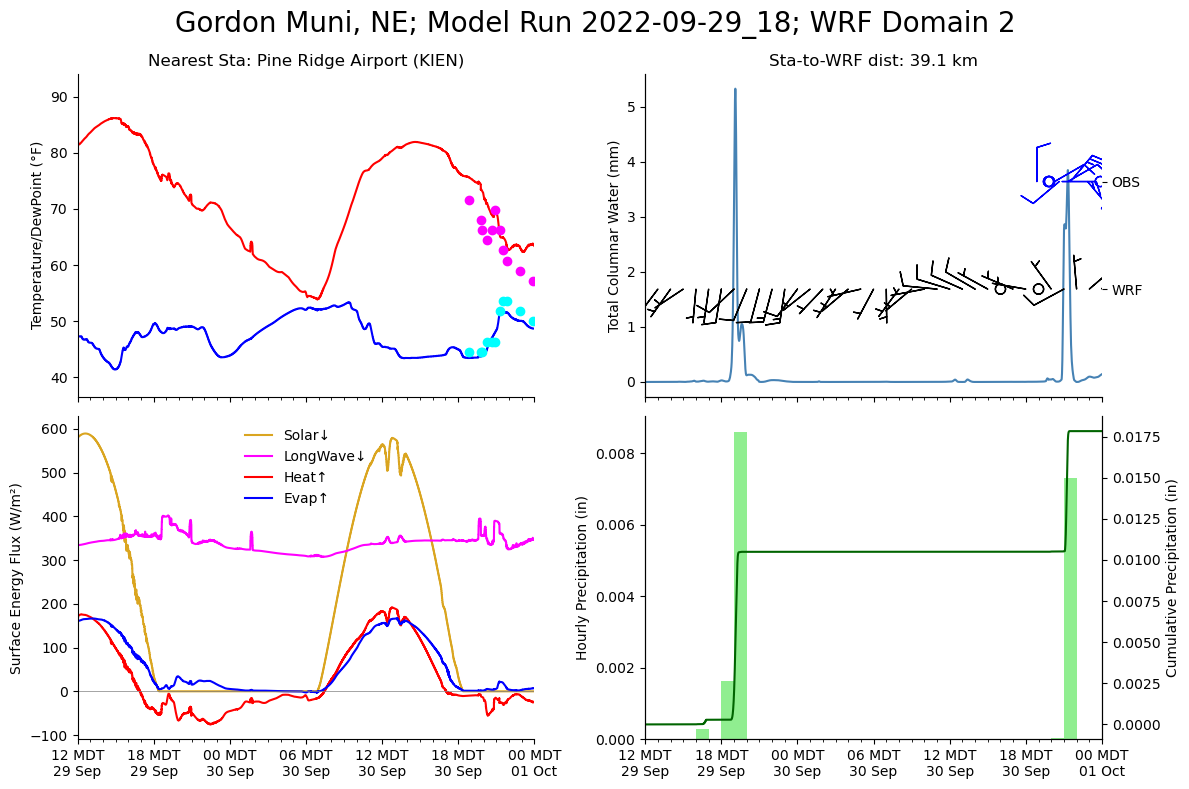

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d02_2022-09-29_18_K4MC.nc
Weatherstation from airport database  Gillette Campbell County Airport
lon metar/station/wrf: -105.55 -104.95 [-104.936]
lat metar/station/wrf: 44.33 44.267 [44.26]
distance between  metar and tslist  48.26113979581281
distance between  metar and    wrf  49.483099036471195
distance between tslist and    wrf  1.3596715726410535
Total precip:  1.8059909448818894  in
DatetimeIndex(['2022-10-29 11:53:00-06:00', '2022-10-29 12:53:00-06:00',
               '2022-10-29 13:53:00-06:00', '2022-10-29 14:53:00-06:00',
               '2022-10-29 15:53:00-06:00', '2022-10-29 16:53:00-06:00',
               '2022-10-29 17:53:00-06:00', '2022-10-29 18:53:00-06:00',
               '2022-10-29 19:53:00-06:00', '2022-10-29 20:53:00-06:00',
               '2022-10-29 21:53:00-06:00', '2022-10-29 22:53:00-06:00',
               '2022-10-29 23:53:00-06:00', '2022-10-30 00:53:00-

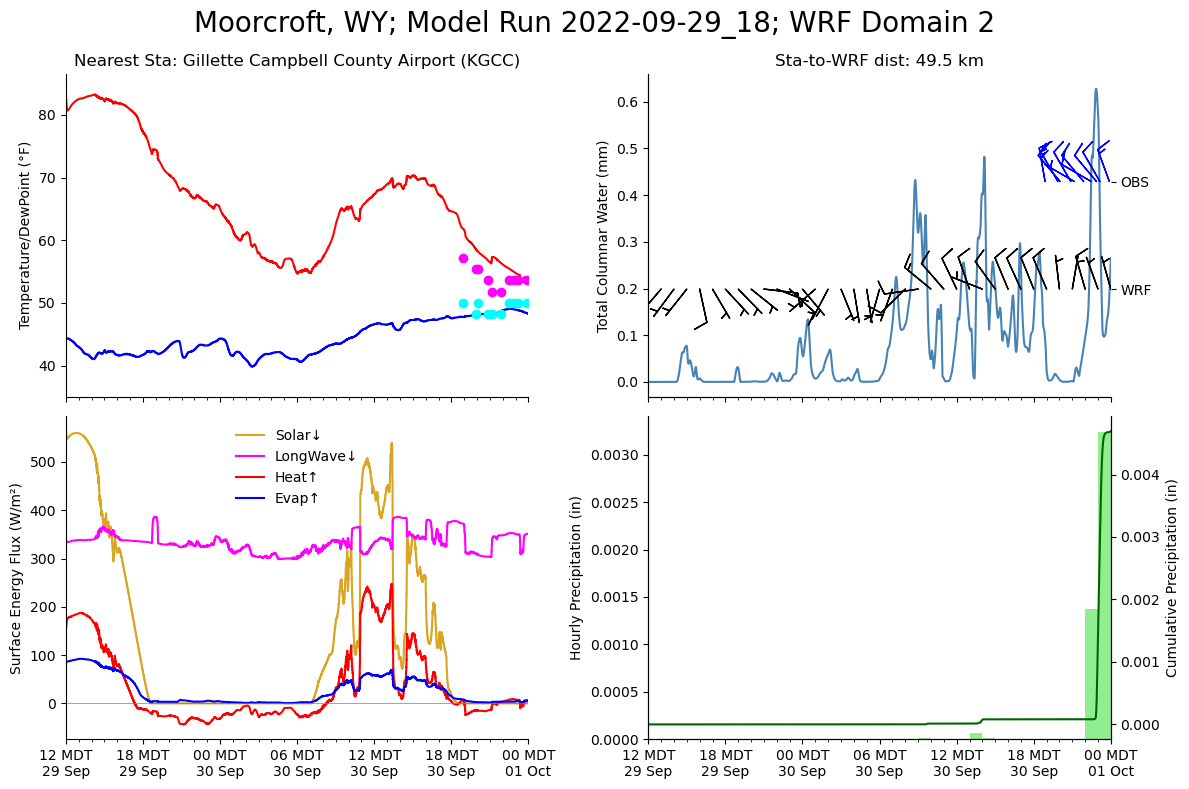

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d02_2022-09-29_18_KHEI.nc
Weatherstation from airport database  Hettinger Municipal Airport
lon metar/station/wrf: -102.65 -102.65 [-102.672]
lat metar/station/wrf: 46.02 46.017 [46.008]
distance between  metar and tslist  0.3335852407011438
distance between  metar and    wrf  2.160266374359072
distance between tslist and    wrf  1.9717894435592607
Total precip:  0.0050748031496063  in
DatetimeIndex(['2022-10-29 11:53:00-06:00', '2022-10-29 12:53:00-06:00',
               '2022-10-29 13:53:00-06:00', '2022-10-29 14:53:00-06:00',
               '2022-10-29 15:53:00-06:00', '2022-10-29 16:53:00-06:00',
               '2022-10-29 17:53:00-06:00', '2022-10-29 18:53:00-06:00',
               '2022-10-29 19:53:00-06:00', '2022-10-29 20:53:00-06:00',
               '2022-10-29 21:53:00-06:00', '2022-10-29 22:53:00-06:00',
               '2022-10-29 23:53:00-06:00', '2022-10-30 00:53:00-06:0

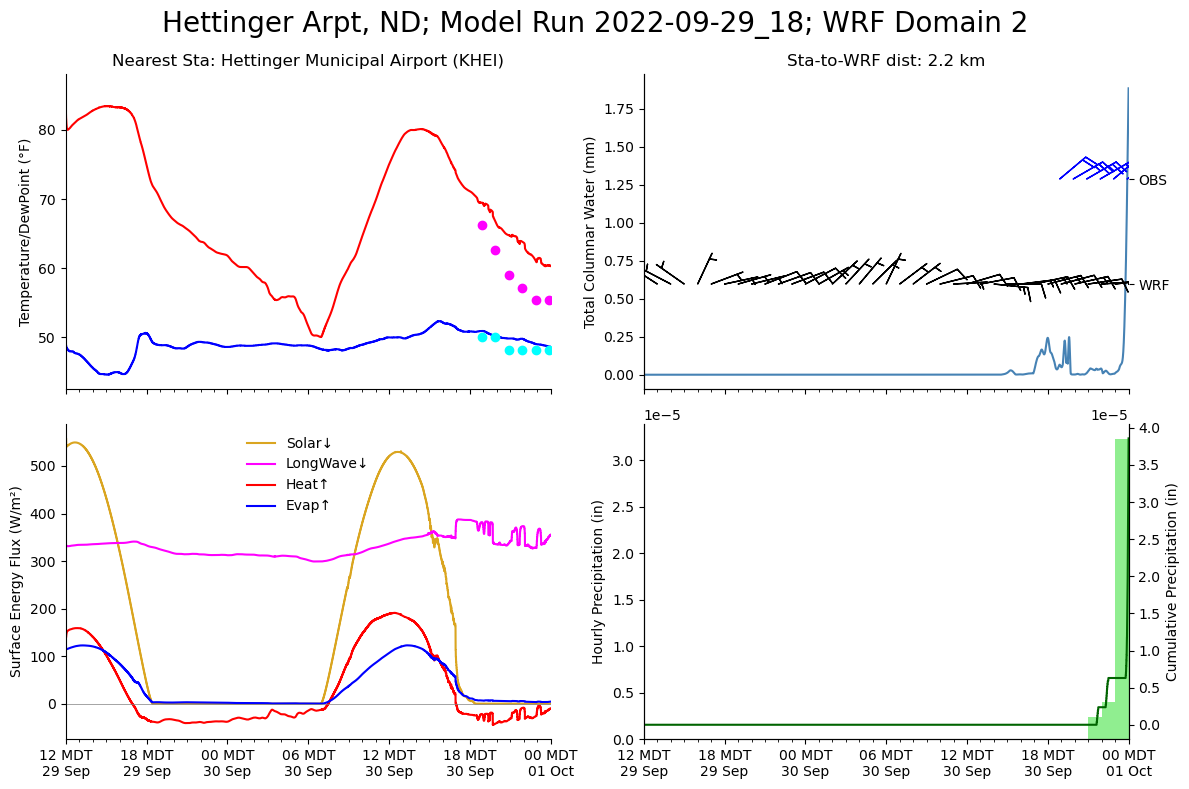

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d01_2022-09-29_18_KAIA.nc
Weatherstation from airport database  Alliance Municipal Airport
lon metar/station/wrf: -102.8 -102.8 [-102.75]
lat metar/station/wrf: 42.05 42.05 [42.042]
distance between  metar and tslist  0.0
distance between  metar and    wrf  4.223458242464319
distance between tslist and    wrf  4.223458242464319
Total precip:  31.02263267716535  in
DatetimeIndex(['2022-10-29 11:53:00-06:00', '2022-10-29 12:53:00-06:00',
               '2022-10-29 13:53:00-06:00', '2022-10-29 14:53:00-06:00',
               '2022-10-29 15:53:00-06:00', '2022-10-29 16:53:00-06:00',
               '2022-10-30 04:53:00-06:00', '2022-10-30 06:53:00-06:00',
               '2022-10-30 07:53:00-06:00', '2022-10-30 08:53:00-06:00',
               '2022-10-30 09:53:00-06:00', '2022-10-30 10:53:00-06:00',
               '2022-10-30 11:53:00-06:00', '2022-10-30 12:53:00-06:00',
               '20

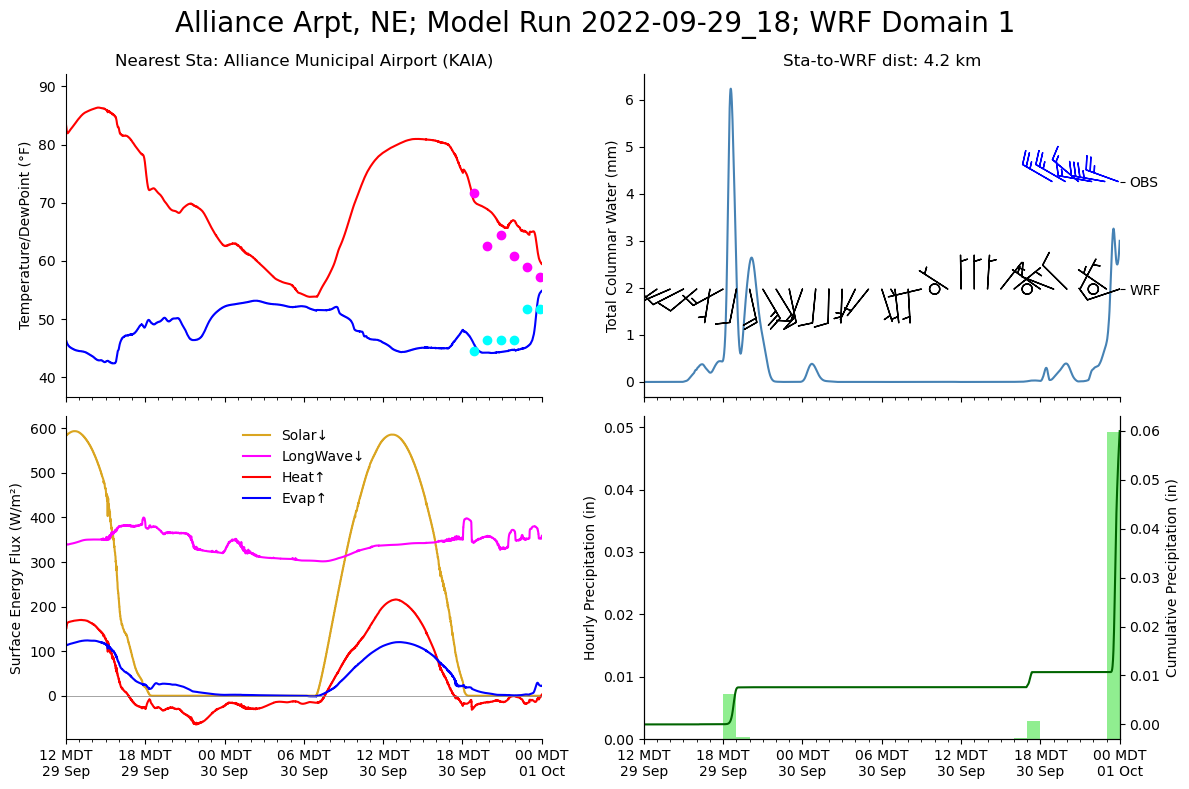

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d02_2022-09-29_18_KBWW.nc
Weatherstation from short table  KBWW
lon metar/station/wrf: -103.3 -103.3 [-103.295]
lat metar/station/wrf: 46.166666666666664 46.1655 [46.168]
distance between  metar and tslist  0.12972759360545022
distance between  metar and    wrf  0.4126007808138126
distance between tslist and    wrf  0.47490909768327155
Total precip:  0.0765720472440945  in
DatetimeIndex(['2022-10-29 11:55:00-06:00', '2022-10-29 12:15:00-06:00',
               '2022-10-29 12:35:00-06:00', '2022-10-29 12:55:00-06:00',
               '2022-10-29 13:15:00-06:00', '2022-10-29 13:35:00-06:00',
               '2022-10-29 13:55:00-06:00', '2022-10-29 14:15:00-06:00',
               '2022-10-29 14:35:00-06:00', '2022-10-29 14:55:00-06:00',
               ...
               '2022-09-30 21:35:00-06:00', '2022-09-30 21:55:00-06:00',
               '2022-09-30 22:15:00-06:00', '2022-09-30 22:35:0

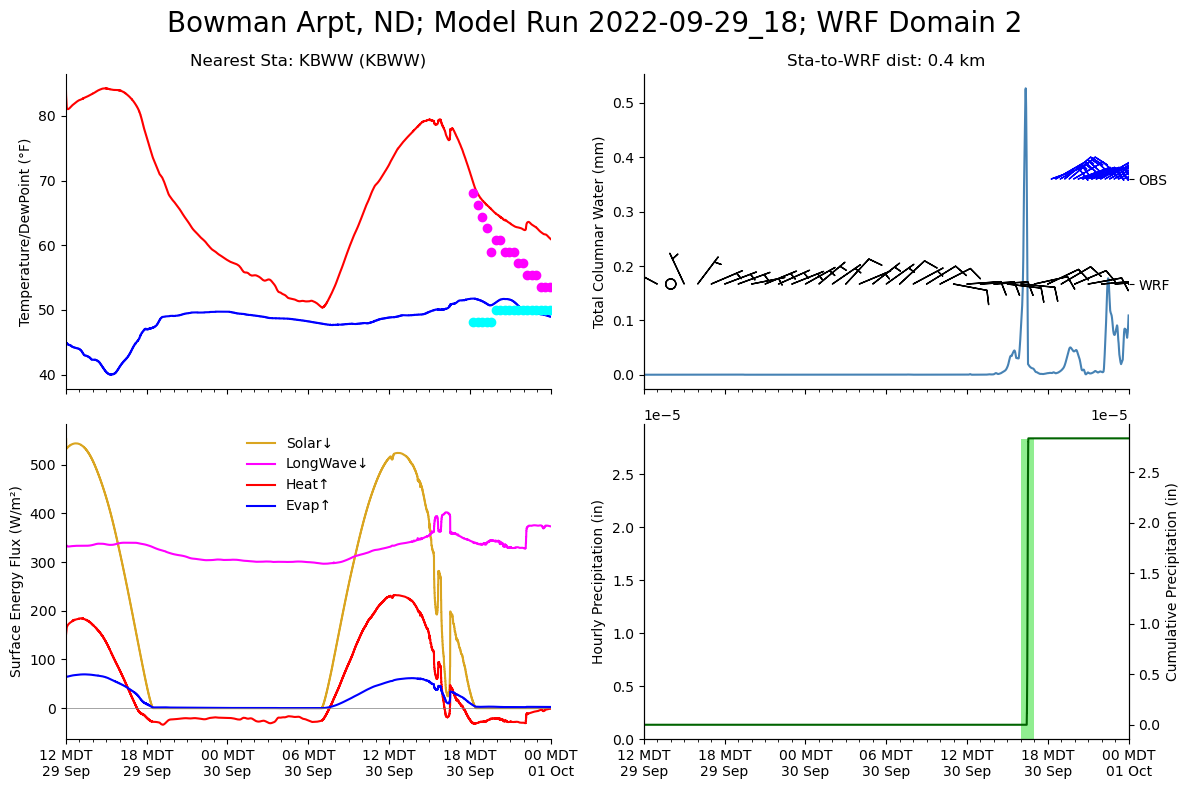

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d02_2022-09-29_18_KY22.nc
Weatherstation from airport database  Hettinger Municipal Airport
lon metar/station/wrf: -102.65 -102.167 [-102.168]
lat metar/station/wrf: 46.02 45.933 [45.926]
distance between  metar and tslist  38.557261903959926
distance between  metar and    wrf  38.687734631025755
distance between tslist and    wrf  0.7821985495285048
Total precip:  19.956015748031497  in
DatetimeIndex(['2022-10-29 11:53:00-06:00', '2022-10-29 12:53:00-06:00',
               '2022-10-29 13:53:00-06:00', '2022-10-29 14:53:00-06:00',
               '2022-10-29 15:53:00-06:00', '2022-10-29 16:53:00-06:00',
               '2022-10-29 17:53:00-06:00', '2022-10-29 18:53:00-06:00',
               '2022-10-29 19:53:00-06:00', '2022-10-29 20:53:00-06:00',
               '2022-10-29 21:53:00-06:00', '2022-10-29 22:53:00-06:00',
               '2022-10-29 23:53:00-06:00', '2022-10-30 00:53:00-06

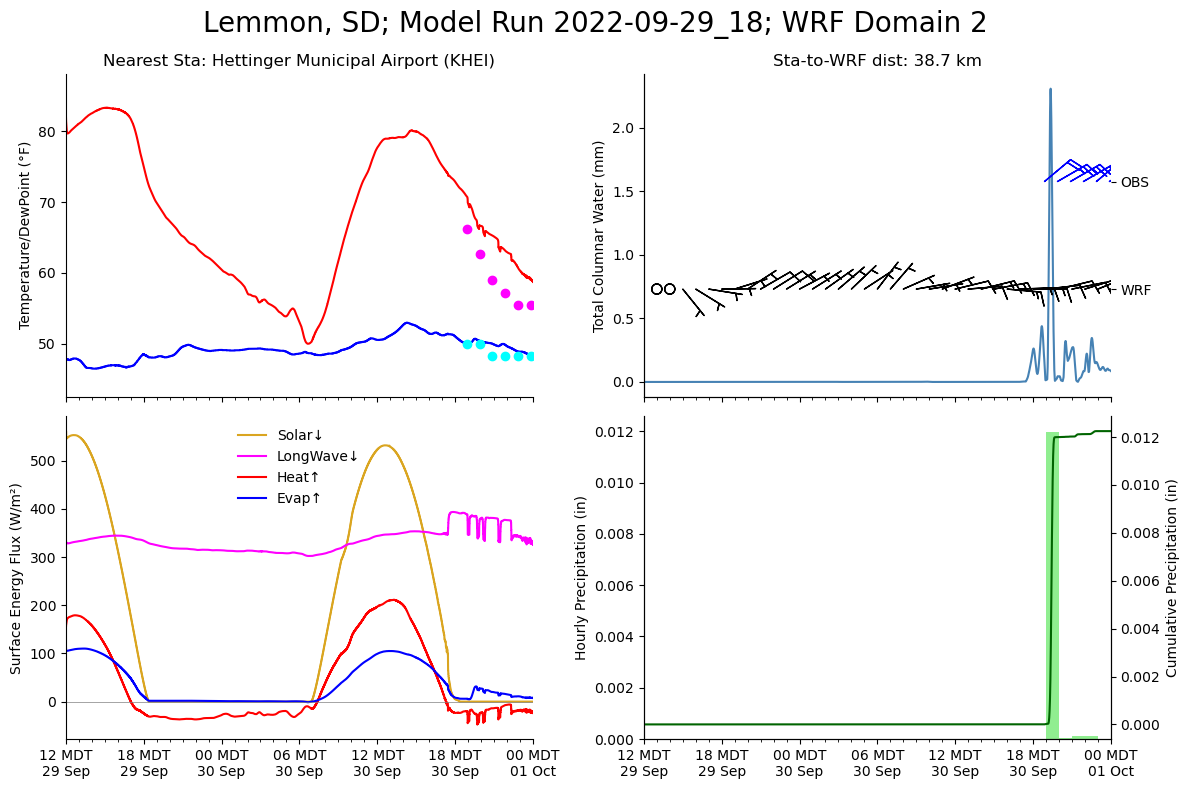

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d02_2022-09-29_18_KLEM.nc
Weatherstation from airport database  Hettinger Municipal Airport
lon metar/station/wrf: -102.65 -102.106 [-102.091]
lat metar/station/wrf: 46.02 45.919 [45.925]
distance between  metar and tslist  43.51717474448776
distance between  metar and    wrf  44.472737760913525
distance between tslist and    wrf  1.3384116227940177
Total precip:  10.3432062992126  in
DatetimeIndex(['2022-10-29 11:53:00-06:00', '2022-10-29 12:53:00-06:00',
               '2022-10-29 13:53:00-06:00', '2022-10-29 14:53:00-06:00',
               '2022-10-29 15:53:00-06:00', '2022-10-29 16:53:00-06:00',
               '2022-10-29 17:53:00-06:00', '2022-10-29 18:53:00-06:00',
               '2022-10-29 19:53:00-06:00', '2022-10-29 20:53:00-06:00',
               '2022-10-29 21:53:00-06:00', '2022-10-29 22:53:00-06:00',
               '2022-10-29 23:53:00-06:00', '2022-10-30 00:53:00-06:00

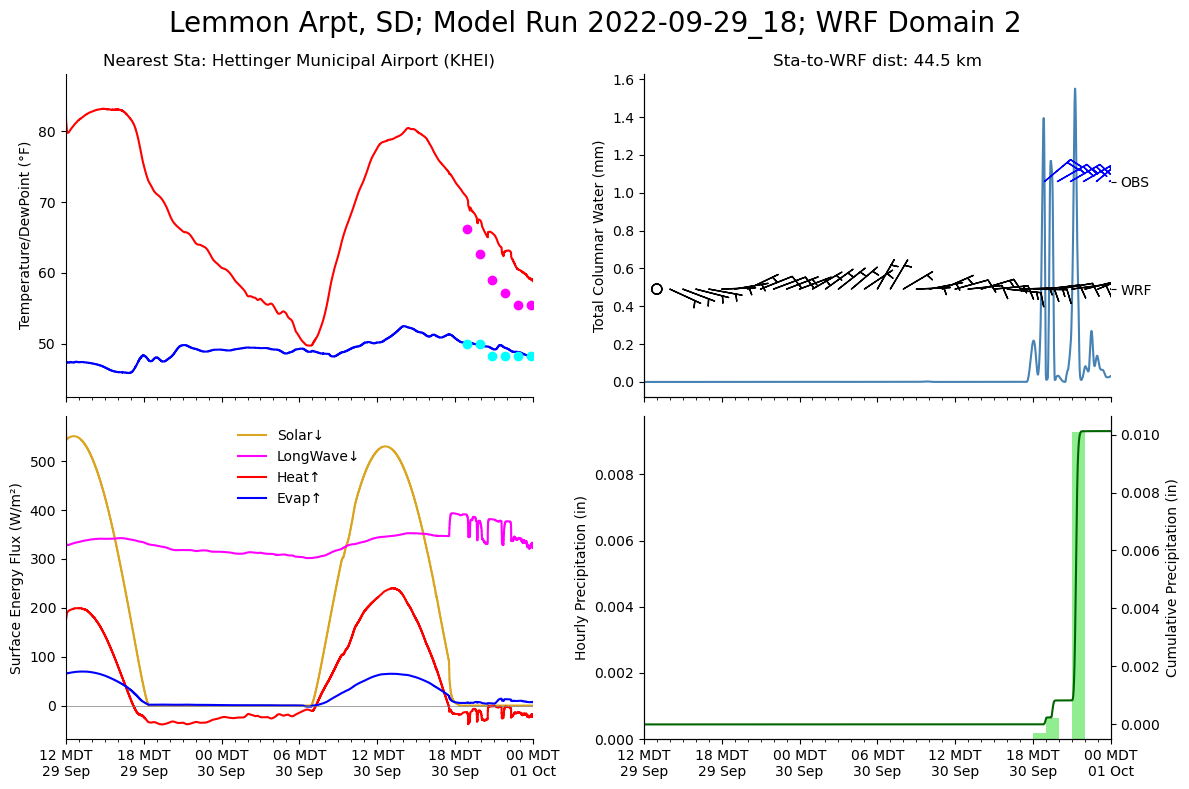

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d01_2022-09-29_18_KTOR.nc
Weatherstation from airport database  Torrington Municipal Airport
lon metar/station/wrf: -104.15 -104.158 [-104.166]
lat metar/station/wrf: 42.07 42.061 [42.033]
distance between  metar and tslist  1.1990116491734861
distance between  metar and    wrf  4.321114013774105
distance between tslist and    wrf  3.1827689534592194
Total precip:  78.24570748031496  in
DatetimeIndex(['2022-10-29 11:53:00-06:00', '2022-10-29 12:53:00-06:00',
               '2022-10-29 13:53:00-06:00', '2022-10-29 14:53:00-06:00',
               '2022-10-29 15:53:00-06:00', '2022-10-29 16:53:00-06:00',
               '2022-10-30 04:53:00-06:00', '2022-10-30 06:53:00-06:00',
               '2022-10-30 07:53:00-06:00', '2022-10-30 08:53:00-06:00',
               '2022-10-30 09:53:00-06:00', '2022-10-30 10:53:00-06:00',
               '2022-10-30 11:53:00-06:00', '2022-10-30 12:53:00-06:

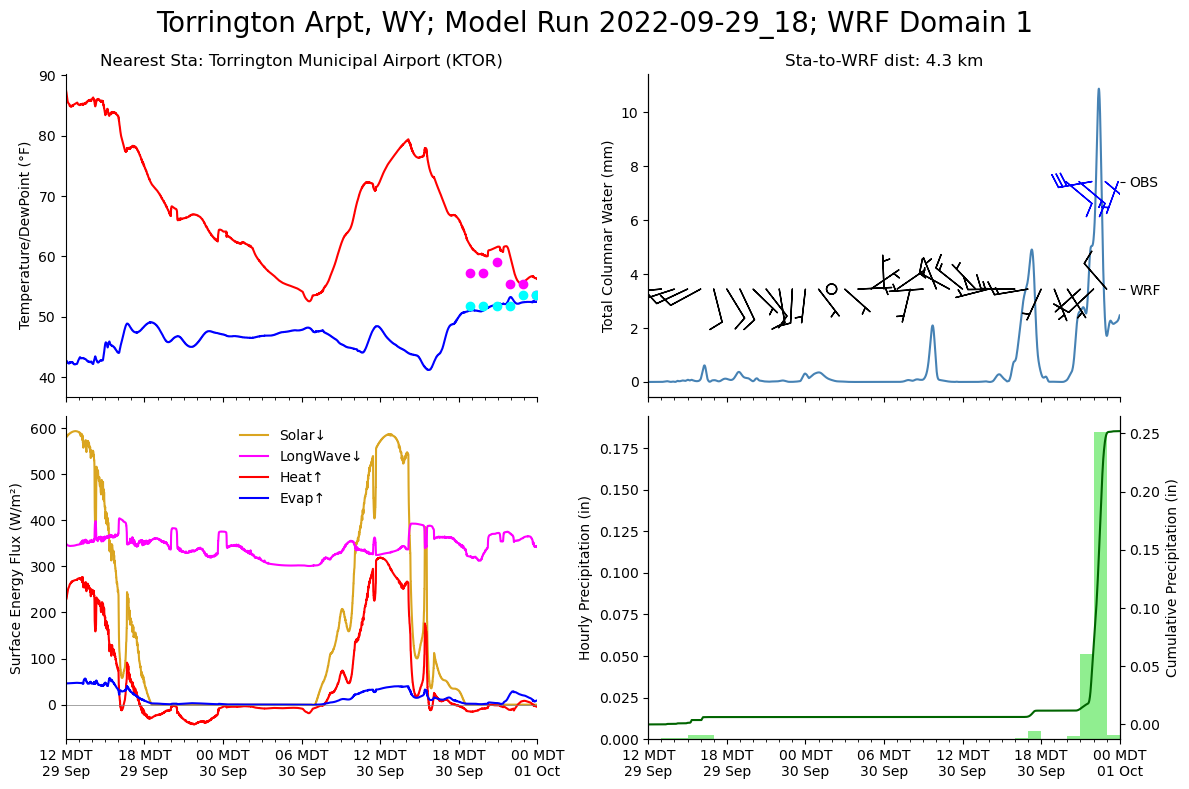

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d01_2022-09-29_18_KBFF.nc
Weatherstation from airport database  Western Neb. Rgnl/William B. Heilig Airport
lon metar/station/wrf: -103.58 -103.593 [-103.619]
lat metar/station/wrf: 41.87 41.871 [41.877]
distance between  metar and tslist  1.0821540682942683
distance between  metar and    wrf  3.3216128092821107
distance between tslist and    wrf  2.253748255228174
Total precip:  120.29189763779529  in
DatetimeIndex(['2022-10-29 11:53:00-06:00', '2022-10-29 12:53:00-06:00',
               '2022-10-29 13:53:00-06:00', '2022-10-29 14:53:00-06:00',
               '2022-10-29 15:53:00-06:00', '2022-10-29 16:53:00-06:00',
               '2022-10-29 17:53:00-06:00', '2022-10-29 18:53:00-06:00',
               '2022-10-29 19:53:00-06:00', '2022-10-29 20:53:00-06:00',
               '2022-10-29 21:53:00-06:00', '2022-10-29 22:53:00-06:00',
               '2022-10-29 23:53:00-06:00', '2022-10

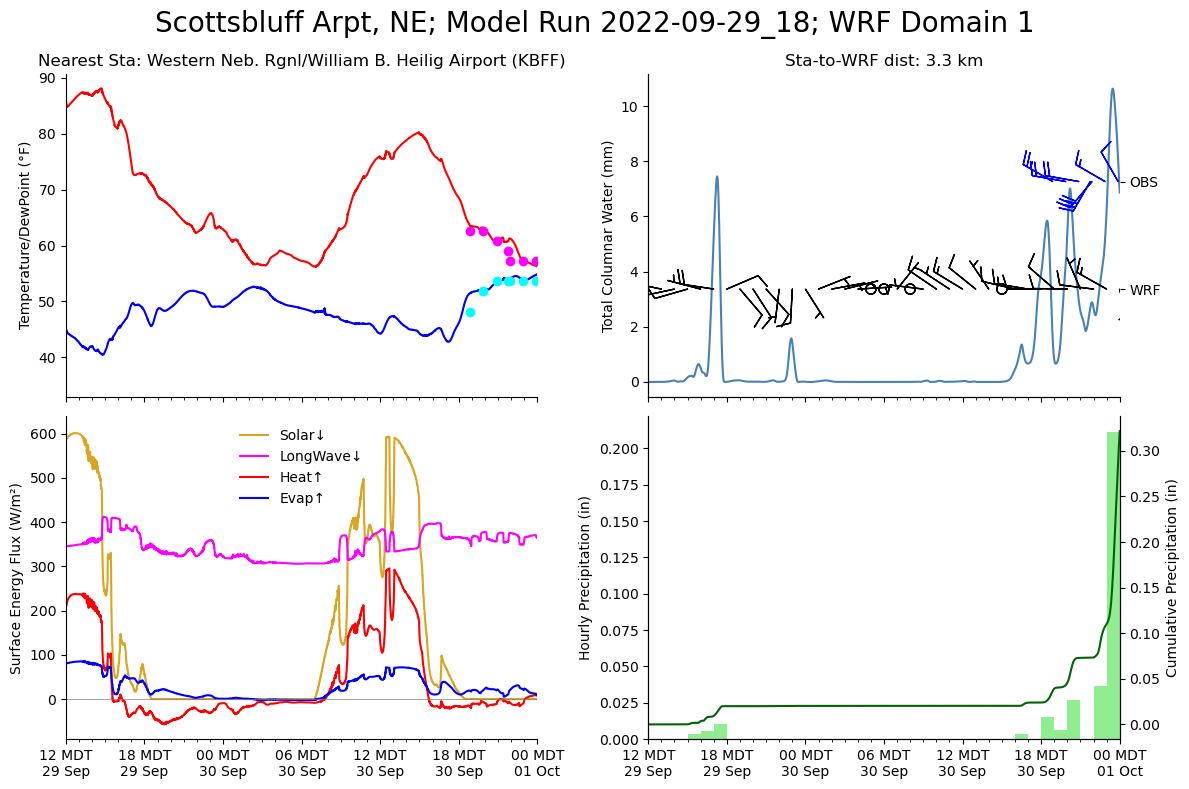

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d02_2022-09-29_18_KGCC.nc
Weatherstation from airport database  Gillette Campbell County Airport
lon metar/station/wrf: -105.55 -105.542 [-105.542]
lat metar/station/wrf: 44.33 44.339 [44.328]
distance between  metar and tslist  1.1859011529407848
distance between  metar and    wrf  0.6740792655015373
distance between tslist and    wrf  1.2231458825685029
Total precip:  208.2469106299213  in
DatetimeIndex(['2022-10-29 11:53:00-06:00', '2022-10-29 12:53:00-06:00',
               '2022-10-29 13:53:00-06:00', '2022-10-29 14:53:00-06:00',
               '2022-10-29 15:53:00-06:00', '2022-10-29 16:53:00-06:00',
               '2022-10-29 17:53:00-06:00', '2022-10-29 18:53:00-06:00',
               '2022-10-29 19:53:00-06:00', '2022-10-29 20:53:00-06:00',
               '2022-10-29 21:53:00-06:00', '2022-10-29 22:53:00-06:00',
               '2022-10-29 23:53:00-06:00', '2022-10-30 00:53:0

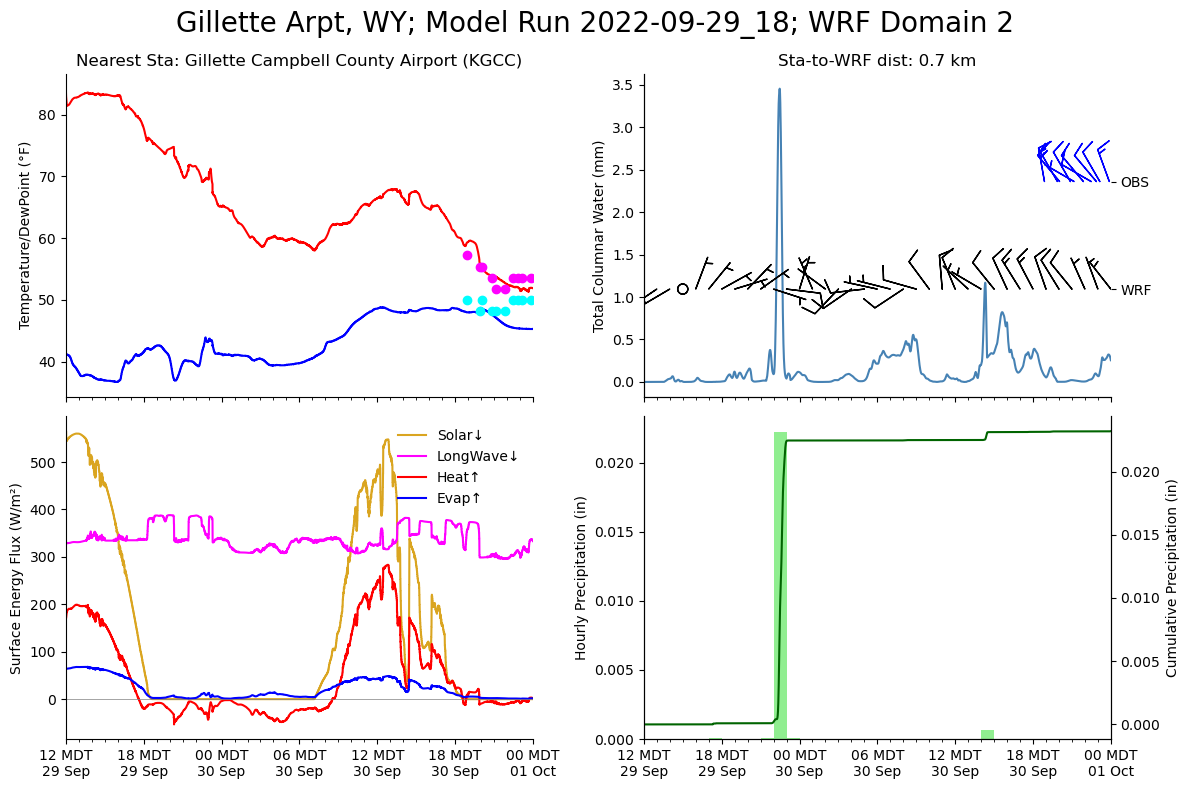

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d01_2022-09-29_18_KSIB.nc
Weatherstation from short table  KGUR
lon metar/station/wrf: -104.73 -105.033 [-105.052]
lat metar/station/wrf: 42.27 42.433 [42.423]
distance between  metar and tslist  30.797456532455712
distance between  metar and    wrf  31.45971907778251
distance between tslist and    wrf  1.9152799122335478
Total precip:  58.69849527559056  in
DatetimeIndex(['2022-10-30 13:56:00-06:00', '2022-10-30 14:56:00-06:00',
               '2022-10-30 15:56:00-06:00', '2022-10-30 16:56:00-06:00',
               '2022-10-30 17:56:00-06:00', '2022-09-30 18:56:00-06:00',
               '2022-09-30 19:56:00-06:00', '2022-09-30 20:56:00-06:00',
               '2022-09-30 21:56:00-06:00', '2022-09-30 22:56:00-06:00',
               '2022-09-30 23:56:00-06:00'],
              dtype='datetime64[ns, America/Denver]', name='date_time', freq=None)
                    station_id  latitude  

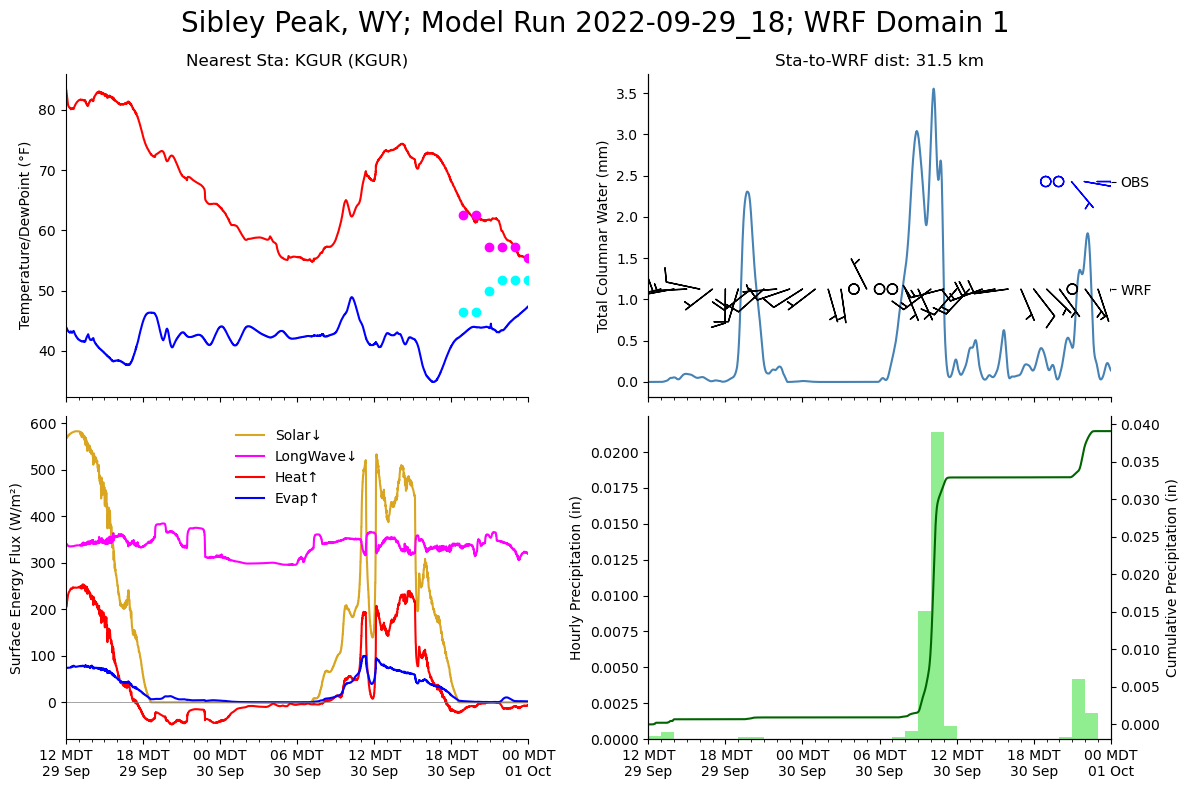

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d02_2022-09-29_18_KDGW.nc
Weatherstation from airport database  Converse County Airport
lon metar/station/wrf: -105.38 -105.38 [-105.397]
lat metar/station/wrf: 42.8 42.796 [42.793]
distance between  metar and tslist  0.44478032093367953
distance between  metar and    wrf  1.5905308682245598
distance between tslist and    wrf  1.4266530683624203
Total precip:  99.42535196850393  in
DatetimeIndex(['2022-10-30 14:53:00-06:00', '2022-10-30 15:53:00-06:00',
               '2022-10-30 16:53:00-06:00', '2022-10-30 17:53:00-06:00',
               '2022-09-30 18:53:00-06:00', '2022-09-30 19:53:00-06:00',
               '2022-09-30 20:53:00-06:00', '2022-09-30 21:53:00-06:00',
               '2022-09-30 22:53:00-06:00', '2022-09-30 23:53:00-06:00'],
              dtype='datetime64[ns, America/Denver]', name='date_time', freq=None)
                    station_id  latitude  longitude  elevation

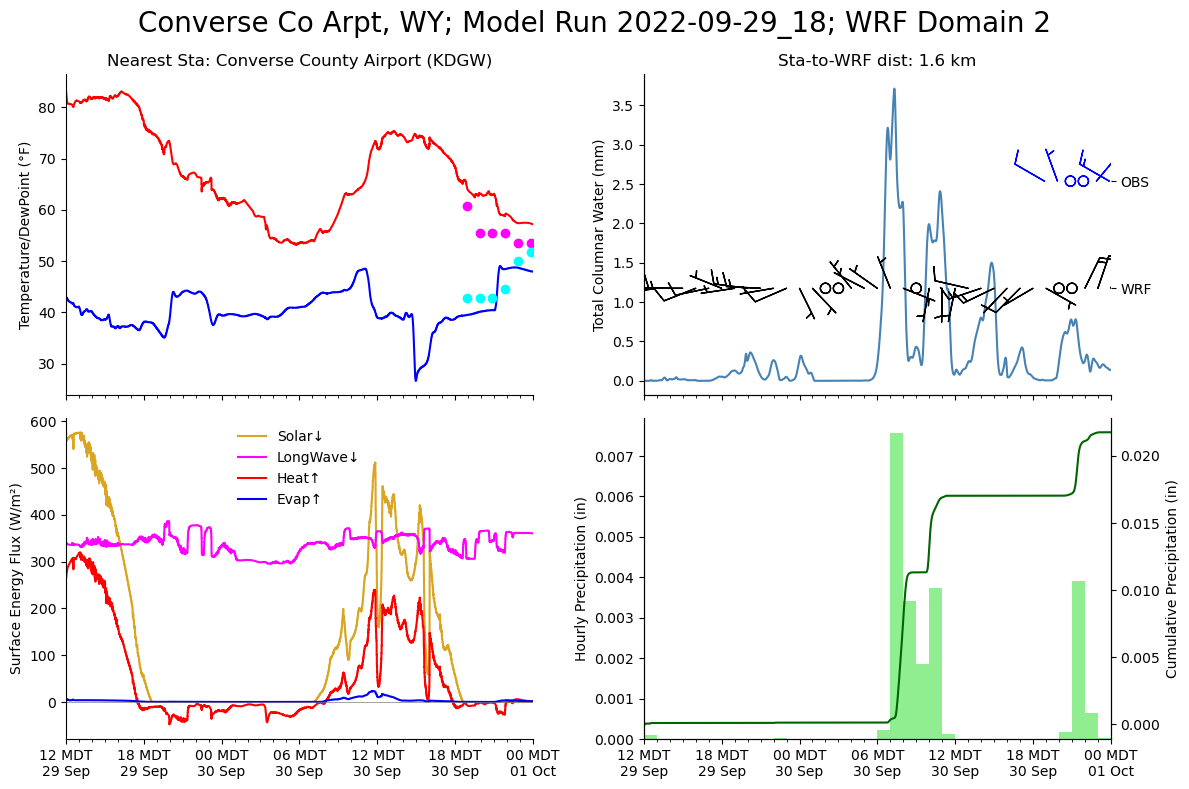

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d02_2022-09-29_18_K4DG.nc
Weatherstation from airport database  Converse County Airport
lon metar/station/wrf: -105.38 -105.383 [-105.395]
lat metar/station/wrf: 42.8 42.75 [42.739]
distance between  metar and tslist  5.565143415565013
distance between  metar and    wrf  6.892525747932241
distance between tslist and    wrf  1.567270236187149
Total precip:  194.55690472440946  in
DatetimeIndex(['2022-10-30 14:53:00-06:00', '2022-10-30 15:53:00-06:00',
               '2022-10-30 16:53:00-06:00', '2022-10-30 17:53:00-06:00',
               '2022-09-30 18:53:00-06:00', '2022-09-30 19:53:00-06:00',
               '2022-09-30 20:53:00-06:00', '2022-09-30 21:53:00-06:00',
               '2022-09-30 22:53:00-06:00', '2022-09-30 23:53:00-06:00'],
              dtype='datetime64[ns, America/Denver]', name='date_time', freq=None)
                    station_id  latitude  longitude  elevation  \

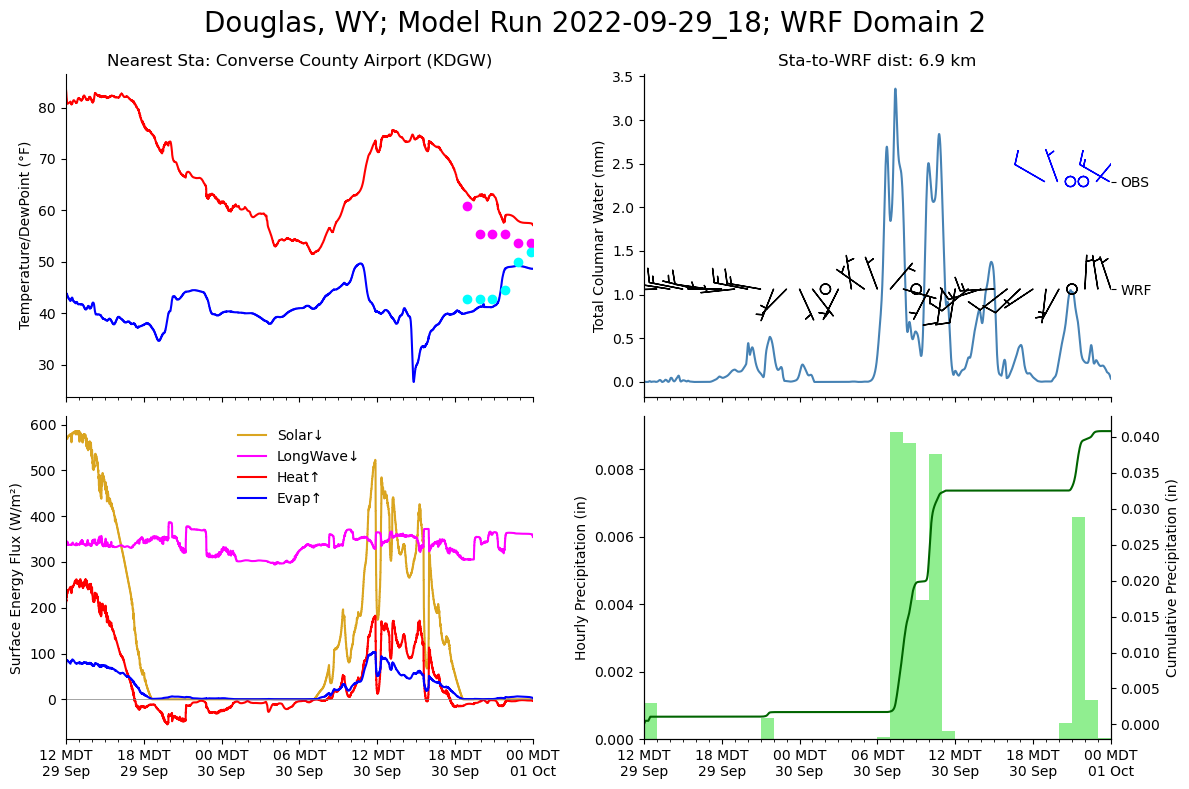

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d02_2022-09-29_18_KMIS.nc
Weatherstation from airport database  Miller Field
lon metar/station/wrf: -100.55 -100.617 [-100.61]
lat metar/station/wrf: 42.87 43.033 [43.02]
distance between  metar and tslist  18.927301378676457
distance between  metar and    wrf  17.37954727267857
distance between tslist and    wrf  1.553496849713234
Total precip:  31.07573700787402  in
DatetimeIndex(['2022-10-29 12:52:00-05:00', '2022-10-29 13:52:00-05:00',
               '2022-10-29 14:52:00-05:00', '2022-10-29 15:52:00-05:00',
               '2022-10-29 16:52:00-05:00', '2022-10-29 17:52:00-05:00',
               '2022-10-29 18:52:00-05:00', '2022-10-29 19:52:00-05:00',
               '2022-10-29 20:52:00-05:00', '2022-10-29 21:52:00-05:00',
               '2022-10-29 22:52:00-05:00', '2022-10-29 23:52:00-05:00',
               '2022-10-30 00:52:00-05:00', '2022-10-30 01:52:00-05:00',
              

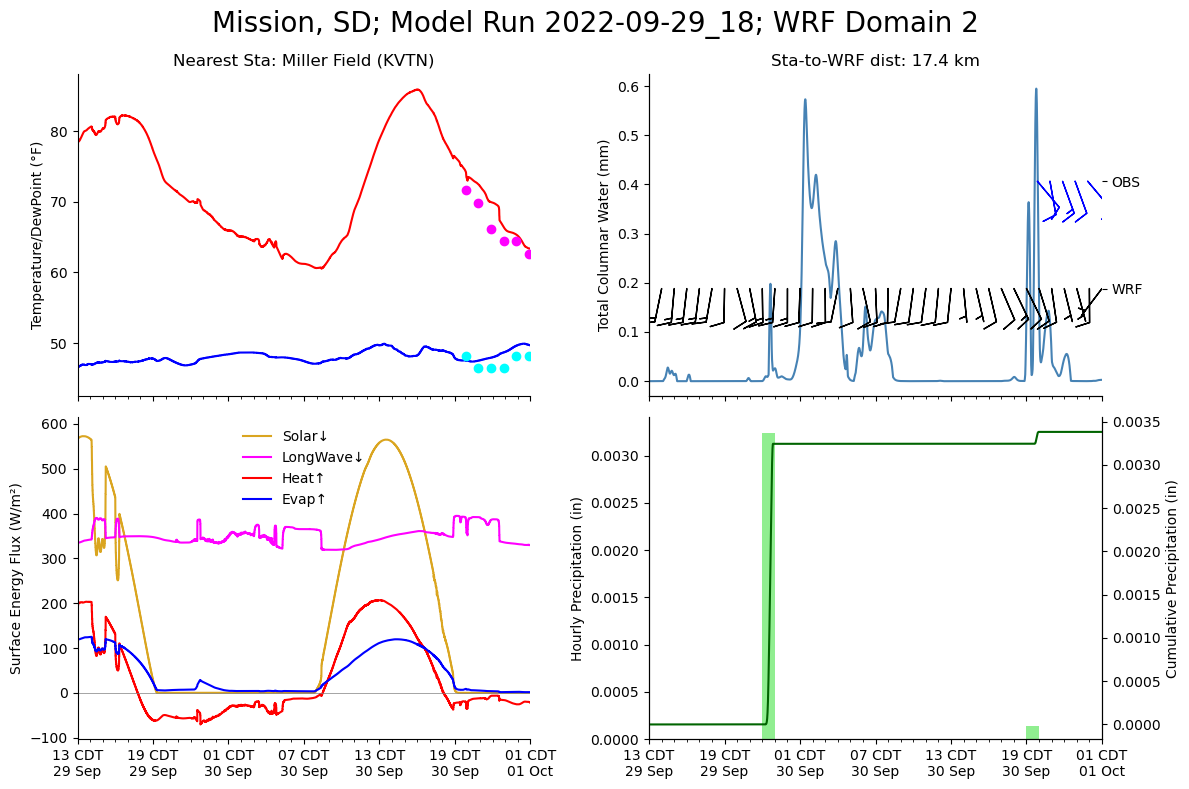

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d02_2022-09-29_18_KVTN.nc
Weatherstation from airport database  Miller Field
lon metar/station/wrf: -100.55 -100.55 [-100.541]
lat metar/station/wrf: 42.87 42.878 [42.883]
distance between  metar and tslist  0.8895606418687737
distance between  metar and    wrf  1.6209301572859793
distance between tslist and    wrf  0.9202603162901246
Total precip:  0.008646062992125985  in
DatetimeIndex(['2022-10-29 12:52:00-05:00', '2022-10-29 13:52:00-05:00',
               '2022-10-29 14:52:00-05:00', '2022-10-29 15:52:00-05:00',
               '2022-10-29 16:52:00-05:00', '2022-10-29 17:52:00-05:00',
               '2022-10-29 18:52:00-05:00', '2022-10-29 19:52:00-05:00',
               '2022-10-29 20:52:00-05:00', '2022-10-29 21:52:00-05:00',
               '2022-10-29 22:52:00-05:00', '2022-10-29 23:52:00-05:00',
               '2022-10-30 00:52:00-05:00', '2022-10-30 01:52:00-05:00',
        

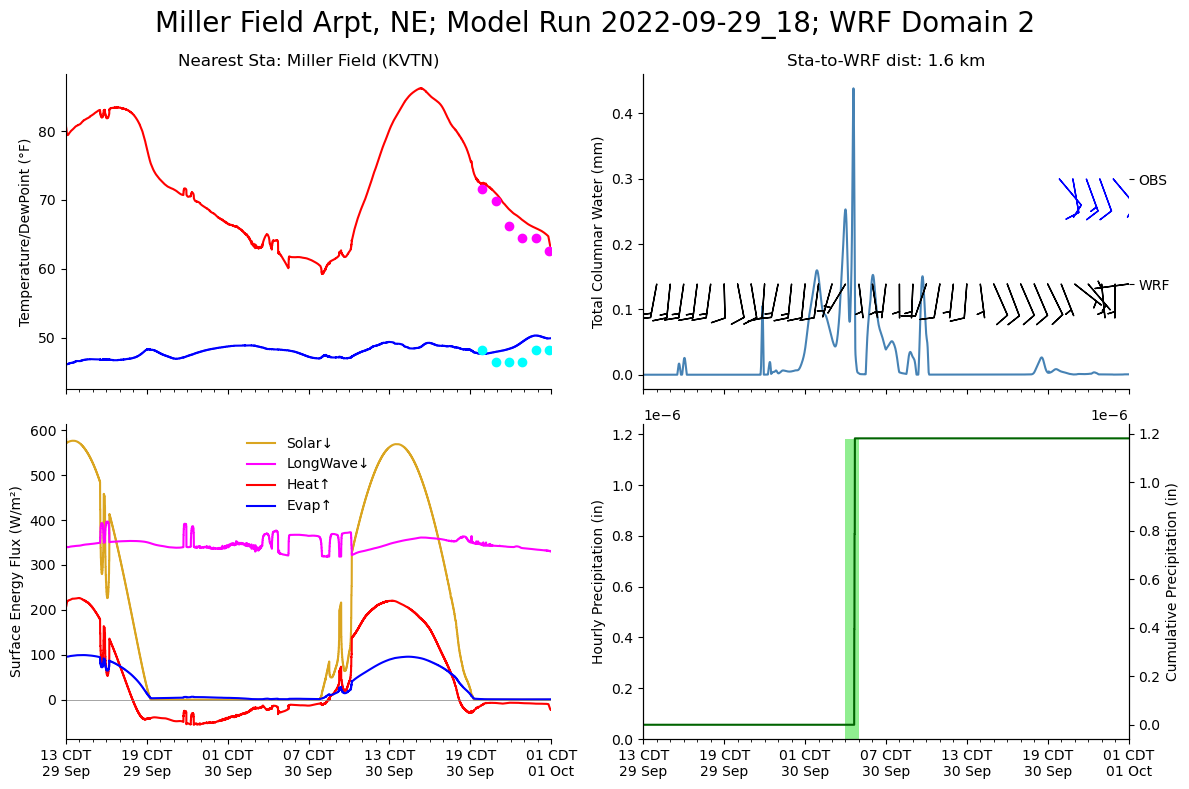

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d02_2022-09-29_18_KPIR.nc
Weatherstation from airport database  Pierre Regional Airport
lon metar/station/wrf: -100.28 -100.286 [-100.295]
lat metar/station/wrf: 44.38 44.381 [44.39]
distance between  metar and tslist  0.4896273434389319
distance between  metar and    wrf  1.6301172685355574
distance between tslist and    wrf  1.2300440884014536
Total precip:  3.2189330708661426  in
DatetimeIndex(['2022-10-29 12:53:00-05:00', '2022-10-29 13:53:00-05:00',
               '2022-10-29 14:53:00-05:00', '2022-10-29 15:53:00-05:00',
               '2022-10-29 16:53:00-05:00', '2022-10-29 17:53:00-05:00',
               '2022-10-29 18:53:00-05:00', '2022-10-29 19:53:00-05:00',
               '2022-10-29 20:53:00-05:00', '2022-10-29 21:53:00-05:00',
               '2022-10-29 22:53:00-05:00', '2022-10-29 23:53:00-05:00',
               '2022-10-30 00:53:00-05:00', '2022-10-30 01:53:00-05:00',

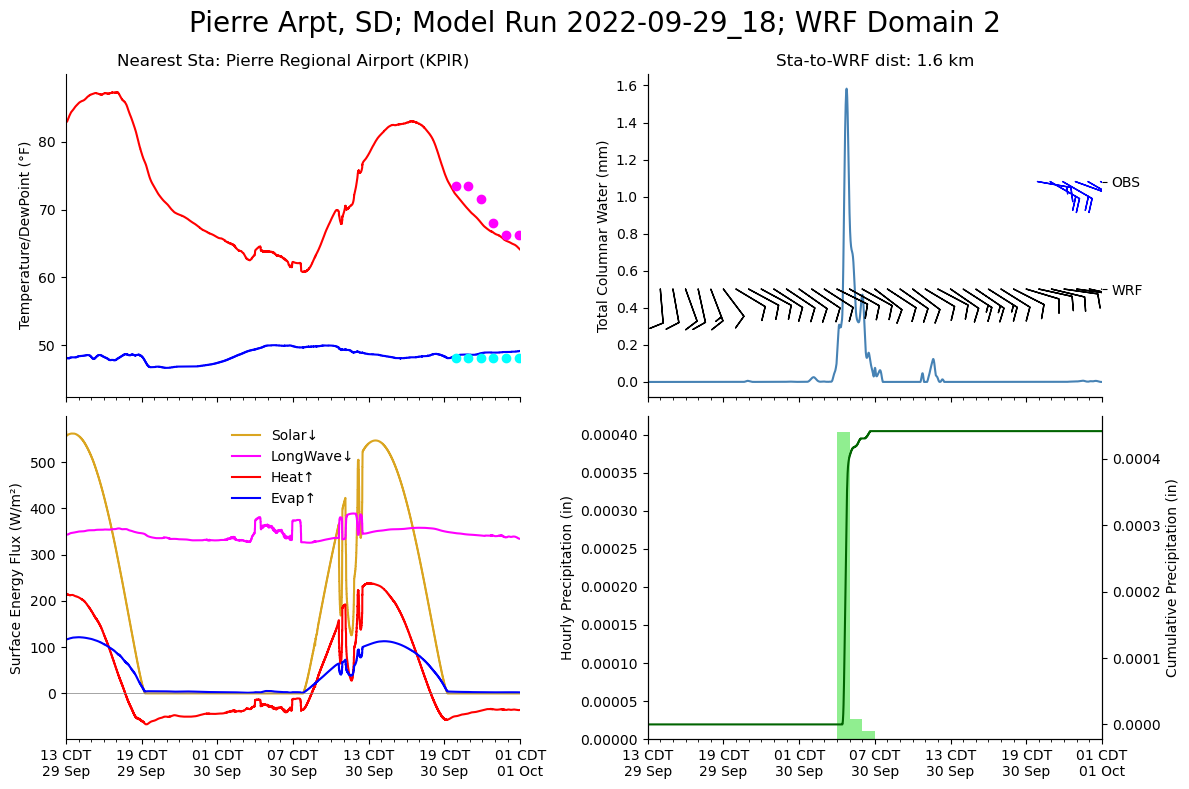

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d01_2022-09-29_18_MUNS.nc
Weatherstation from airport database  Robertson Field
lon metar/station/wrf: -98.4 -98.835 [-98.835]
lat metar/station/wrf: 48.75 48.6667 [48.695]
distance between  metar and tslist  33.23562647533769
distance between  metar and    wrf  32.490640459565384
distance between tslist and    wrf  3.1468207706089832
Total precip:  0.0  in
No Significant Rainfall
DatetimeIndex(['2022-10-29 12:55:00-05:00', '2022-10-29 13:15:00-05:00',
               '2022-10-29 13:35:00-05:00', '2022-10-29 13:55:00-05:00',
               '2022-10-29 14:15:00-05:00', '2022-10-29 14:35:00-05:00',
               '2022-10-29 14:55:00-05:00', '2022-10-29 15:15:00-05:00',
               '2022-10-29 15:35:00-05:00', '2022-10-29 15:55:00-05:00',
               ...
               '2022-09-30 21:55:00-05:00', '2022-09-30 22:15:00-05:00',
               '2022-09-30 22:35:00-05:00', '2022-09-30

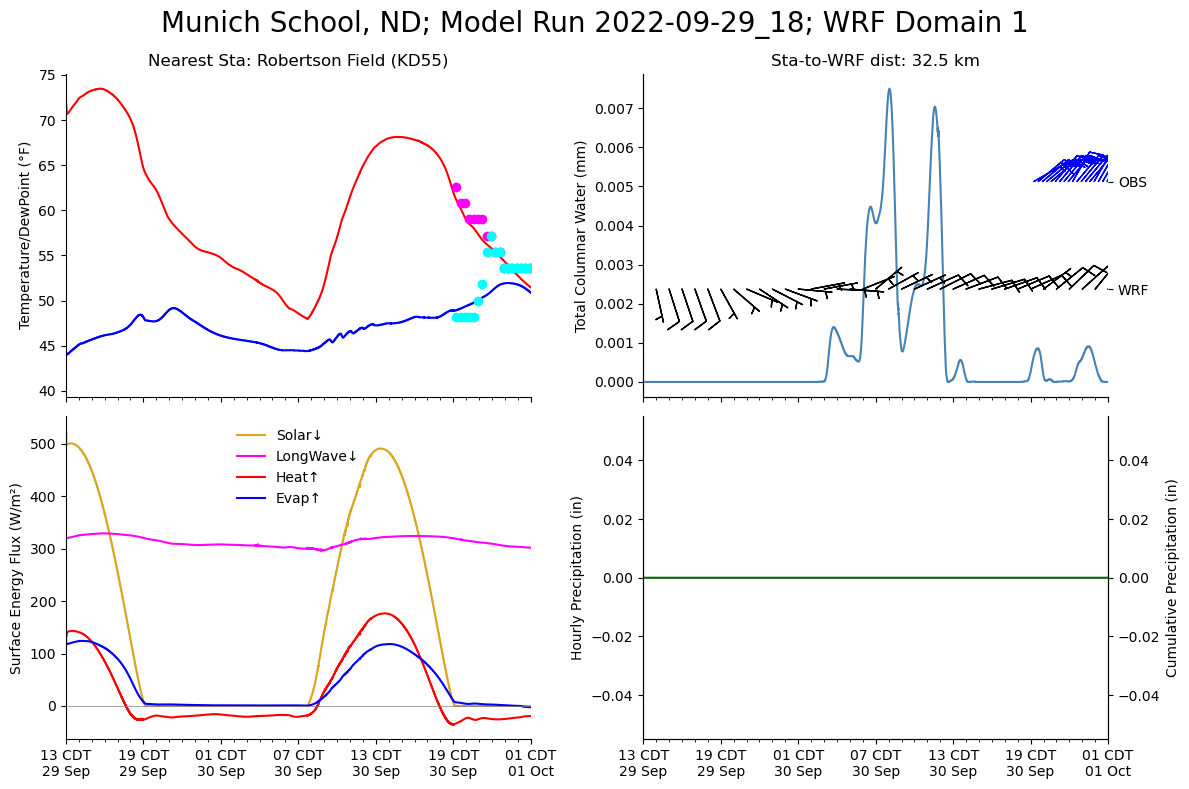

In [7]:
####################################################
####################################################
####################################################
#
# Rotate through Available Files
#

file_time = model_start_datetime.strftime('%Y-%m-%d_%H')

TS_DIR    = WRF_ARCHIVE  + "./current_complete_run/STATION_TIME_SERIES/"

#
# Creating Graphics Directory
#

graphics_directory = WRF_IMAGES + "./current_complete_run/STATION_TIME_SERIES/"

print("Creating " + graphics_directory)

os.system("mkdir -pv " + graphics_directory )

#
# Start File Rotation
#

for station in available_time_series_list.iterrows():

    ###################################################################
    #
    # Pull Station Data 
    #

    station_id     = station[1][0]
    grid_domain    = station[1][1]
    station_name   = station[1][2]
    station_lat    = station[1][3]
    station_lon    = station[1][4]

    #    
    ###################################################################

    ###################################################################
    #
    # Pull WRF Time Series
    #
    
    netcdf_file_name = TS_DIR + "./wrfout_d"+str(grid_domain).zfill(2)+"_"+file_time+"_"+station_id+".nc"
    
    wrf_timeseries = xr.open_dataset(netcdf_file_name, 
                                     engine='netcdf4')
    
    print(netcdf_file_name)

    #
    ###################################################################

    ###################################################################
    #
    # Select Metars for Closest Station
    #

  

    ###################################################################
    #
    # Get METARS for Station 
    #
    


    #
    # Get Nearest Station to Requested Station Point
    #
    
    metar_station_locs['distance'] = metar_station_locs.apply(lambda row: haversine(row), axis=1)
    
    x=metar_station_locs[ metar_station_locs['distance'] == metar_station_locs['distance'].min() ]

    try:
        weather_station_name = airport_database[x['station_id'][0]]["name"] #+", "+airport_database[x['station_id'][0]]["subd"]
        print("Weatherstation from airport database ", weather_station_name)
    except KeyError:
        weather_station_name = x['station_id'][0]
        print("Weatherstation from short table ", weather_station_name)

               
    metar_data = metar_dataframe[metar_dataframe["station_id"]==x["station_id"][0]].set_index("date_time")
    

    
    
    print("lon metar/station/wrf:",metar_data["longitude"][0],station_lon,wrf_timeseries["wrf_grid_longitude"].values)
    print("lat metar/station/wrf:",metar_data["latitude"][0],station_lat,wrf_timeseries["wrf_grid_latitude"].values)

   

    metar_to_sta_distance  = hs.haversine((metar_data["latitude"][0],
                                           metar_data["longitude"][0]),
                                          (station_lat,
                                           station_lon))

    metar_to_wrf_distance = hs.haversine((metar_data["latitude"][0],
                                           metar_data["longitude"][0]),
                                          (wrf_timeseries["wrf_grid_latitude"].values,
                                           wrf_timeseries["wrf_grid_longitude"].values))


    sta_to_wrf_distance   = hs.haversine((station_lat,
                                          station_lon),
                                         (wrf_timeseries["wrf_grid_latitude"].values,
                                          wrf_timeseries["wrf_grid_longitude"].values))    
    
    print("distance between  metar and tslist ",metar_to_sta_distance)
    print("distance between  metar and    wrf ",metar_to_wrf_distance)
    print("distance between tslist and    wrf ",sta_to_wrf_distance)

    
    
    #    
    ###################################################################    

        







    #
    ###################################################################    
    

    ###################################################################
    ###################################################################
    #
    # Create Meteogram
    #

    ###################################################################
    #
    # Time Axes
    #
                                         
    tf     = tzf.TimezoneFinder()
    tz     = tf.certain_timezone_at(lng=station_lon, lat=station_lat)
    
    tzabbr = pytz.timezone(tz).localize(model_start_datetime)

    wrf_times  = pd.to_datetime(wrf_timeseries["time"]).tz_localize(tz="UTC").tz_convert(tz=tz)
    
    ncss_times = pd.to_datetime(metar_data.index).tz_localize(tz="UTC").tz_convert(tz=tz)



    wrf_time_seconds  =  wrf_times.minute*60+wrf_times.second 
    on_the_hour       = np.where(wrf_time_seconds ==0)
    wrf_time_hrly     = wrf_times[on_the_hour]
    wrf_time_hrly_bar = wrf_times[on_the_hour]-datetime.timedelta(minutes=30)

    #
    ###################################################################


    ###################################################################
    #
    # Precip Prep
    #

    wrf_cum_prec      = wrf_timeseries["stratiform_precipitation_amount"].values + wrf_timeseries["convective_precipitation_amount"].values
    print("Total precip: ",np.sum(wrf_cum_prec)/25.4, " in")
    if (np.sum(wrf_cum_prec)/25.4 < 0.005):
        print("No Significant Rainfall")
        wrf_cum_prec[:] = 0.000
    
    wrf_cum_hrly_prec = wrf_cum_prec[on_the_hour]
    wrf_hrly_prec     = wrf_cum_hrly_prec.copy()

    wrf_hrly_prec[1:] = wrf_cum_hrly_prec[1:] - wrf_cum_hrly_prec[0:-1]
    
    wrf_hrly_prec     = wrf_hrly_prec     / 25.4
    wrf_cum_hrly_prec = wrf_cum_hrly_prec / 25.4
    wrf_cum_prec      = wrf_cum_prec      / 25.4

    #
    ###################################################################

    ###################################################################
    #
    # Wind Barb Prep
    #

    u_wrf = (wrf_timeseries["eastward_wind_10m"]*units("m")/units("s")).pint.to("knots")[on_the_hour]
    v_wrf = (wrf_timeseries["northward_wind_10m"]*units("m")/units("s")).pint.to("knots")[on_the_hour]



    obs_winddir   =  metar_data["wind_direction"].to_numpy() * units("deg")
    obs_windspeed = (metar_data["wind_speed"].to_numpy() * units("m")/units("s")).to("knots") 



    u_obs = (metar_data[ "eastward_wind"].to_numpy() * units("m")/units("s")).to("knots") 
    v_obs = (metar_data["northward_wind"].to_numpy() * units("m")/units("s")).to("knots") 

    #
    ###################################################################

    ###################################################################
    #
    # Plot Meteogram
    #

    fig, ax = plt.subplots(figsize = (12, 8),
                           nrows   =  2, 
                           ncols   =  2,
                           sharex  =  True)

    date_form = mdates.DateFormatter("%H %Z\n%d %b", tz=pytz.timezone(tz))
    xmajor = mdates.HourLocator(interval = 6)
    xminor = mdates.HourLocator(interval = 1)
    
    print(ncss_times)
    print(metar_data)
    
    

    #
    # Temperature and Humidity
    #
    
    ax[0,0].plot(wrf_times,
             (wrf_timeseries["air_temperature_2m"]*units("K")).pint.to("degF"),
              color = "red")
    ax[0,0].plot(wrf_times,
             (wrf_timeseries["dew_point_temperature_2m"]*units("K")).pint.to("degF"),
              color = "blue")
    ax[0,0].set_ylabel("Temperature/DewPoint (°F)")


    try:
        ax[0,0].plot(ncss_times,
                 (metar_data["air_temperature"].to_numpy()*units("degC")).to("degF"),
                 marker = "o",
                 color="magenta",
                linestyle = "None")
    except ValueError:
        print("balls: air_temperature plot error")

    try:
        ax[0,0].plot(ncss_times,
                 (metar_data["dew_point_temperature"].to_numpy()*units("degC")).to("degF"),
                 marker = "o",
                 color="cyan",
                linestyle = "None")
    except ValueError:
        print("balls: dew_point_temperature plot error")


    ax[0,1].set_title("Sta-to-WRF dist: "+str(round(metar_to_wrf_distance,1)) +" km")
    ax[0,0].set_title("Nearest Sta: "+weather_station_name +" ("+x['station_id'][0] +")")
        


    #
    # Total Atmos Column Water + Wind Speed
    #
    
    ax[0,1].plot(wrf_times,
            wrf_timeseries["atmosphere_mass_content_of_water"],
              color = "steelblue")
    ax[0,1].set_ylabel("Total Columnar Water (mm)")
 

    ax01 = ax[0,1].twinx()
    
    ax01.set_ylim(0,1)
    ax01.set_yticks([1/3.,2/3.])
    ax01.set_yticklabels(["WRF","OBS"])

    
    ax01.barbs( wrf_time_hrly, 1/3.,  u_wrf, v_wrf )

    try:
        ax01.barbs( ncss_times,    2/3.,  u_obs, v_obs, color="blue")
    except ValueError:
        print("balls: wind plotting error")

   
    
    #
    # Surface Energy Budget
    #

    ax[1,0].plot(wrf_times,
                 wrf_timeseries["surface_net_downward_shortwave_flux"],
                 color = "goldenrod")
    ax[1,0].plot(wrf_times,
                 wrf_timeseries["surface_net_downward_longwave_flux"],
                 color = "magenta")
    ax[1,0].plot(wrf_times,
                 wrf_timeseries["surface_upward_sensible_heat_flux"],
                 color = "red")
    ax[1,0].plot(wrf_times,
                 wrf_timeseries["surface_upward_latent_heat_flux"],
                 color = "blue")
    ax[1,0].legend(["Solar↓",
                    "LongWave↓",
                    "Heat↑",
                    "Evap↑"],
                  frameon=False)
    ax[1,0].set_ylabel("Surface Energy Flux (W/m²)")

    ax[1,0].axhline(y=0,color="grey", linewidth=0.5)
 
    #
    # Precipitation
    #

    ax[1,1].bar(wrf_time_hrly_bar,
                wrf_hrly_prec,
                linewidth=0,
                width=1/24, 
                color="lightgreen",
                edgecolor=None)
    ax11 = ax[1,1].twinx()
    ax11.plot(wrf_times,
              wrf_cum_prec, 
              color="darkgreen")
    ax11.set_ylabel("Cumulative Precipitation (in)")
    ax[1,1].set_ylabel("Hourly Precipitation (in)")

    fig.suptitle(station_name+"; Model Run "+file_time+"; WRF Domain "+str(grid_domain),
                 fontsize=20)


    ax[1,0].set_xlim(model_start_datetime, model_end_datetime)
    ax[1,0].xaxis.set_major_formatter(date_form)
    ax[1,0].xaxis.set_major_locator(xmajor)
    ax[1,0].xaxis.set_minor_locator(xminor)
    ax[1,0].xaxis_date()

    ax[1,1].set_xlim(model_start_datetime, model_end_datetime)
    ax[1,1].xaxis.set_major_formatter(date_form)
    ax[1,1].xaxis.set_major_locator(xmajor)
    ax[1,1].xaxis.set_minor_locator(xminor)
    ax[1,1].xaxis_date()

    ax[0,0].set_xlim(model_start_datetime, model_end_datetime)
    ax[0,0].xaxis.set_major_formatter(date_form)
    ax[0,0].xaxis.set_major_locator(xmajor)
    ax[0,0].xaxis.set_minor_locator(xminor)
    ax[0,0].xaxis_date()

    ax[0,1].set_xlim(model_start_datetime, model_end_datetime)
    ax[0,1].xaxis.set_major_formatter(date_form)
    ax[0,1].xaxis.set_major_locator(xmajor)
    ax[0,1].xaxis.set_minor_locator(xminor)
    ax[0,1].xaxis_date()

    ax[0,0].spines["top"].set_visible(False)
    ax[1,0].spines["top"].set_visible(False)
    ax[0,1].spines["top"].set_visible(False)
    ax[1,1].spines["top"].set_visible(False)
    ax11.spines[   "top"].set_visible(False)
    ax01.spines[   "top"].set_visible(False)

    ax[0,0].spines["right"].set_visible(False)
    ax[1,0].spines["right"].set_visible(False)
    ax[0,1].spines["right"].set_visible(False)
    ax01.spines[   "right"].set_visible(False)

    
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)


    # plt.show()
    if (platform.system() != "Darwin"):
        fig.savefig(graphics_directory + "./wrfout_dxx_"+file_time+"_"+station_id+".png",
                        facecolor   = 'white', 
                        transparent =   False)
    else:
        plt.show()

    plt.close('all')


    #
    ###################################################################

    #
    ###################################################################
    ###################################################################
    
    print(" ")



## Depart 

In [8]:
####################################################
####################################################
####################################################
#
# End of Script
#

print("Ploting Meteogram Script complete.")

#
####################################################
####################################################
####################################################

Ploting Meteogram Script complete.
